In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# the next line should be changed so that the path to the data file corresponds to your local machine and i left it as path not to doxx my own directory lmao
# make sure that jupyter runs on the same directory as the train data
#os.chdir('PATH') # for jupyter


# load the dataset
data = pd.read_csv('Train_data.csv')

# 1(a) List the data fields (columns)
print("Data Fields (Columns):")
print(data.columns)

# 1(b) list the types of the data fields (columns)
print("\nData Types:")
print(data.dtypes)

# 1(c) check if there is any missing data or infinite data
print("\nMissing Data Check:")
print(data.isnull().sum())

print("\nInfinite Data Check:")
# only check data types that could be classified as a type of number
for col in data.select_dtypes(include=[np.number]).columns:
    print(f"{col}: {np.isinf(data[col]).sum()} infinite values")

# 1(d) print the number of categories in each field
print("\nnumber of categories in each field:")
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"{col}: {data[col].nunique()} categories")
    else:
        print(f"{col}: not categorical")

# 1(e) print the maximum, minimum, average, and variance for each numeric field
print("\nstatistics for numeric fields:")
for col in data.select_dtypes(include=[np.number]).columns:
    print(f"\nfield: {col}")
    print(f"max: {data[col].max()}")
    print(f"min: {data[col].min()}")
    print(f"average: {data[col].mean()}")
    print(f"variance: {data[col].var()}")

Data Fields (Columns):
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

Data Types:
duration                         int64
protocol_type                   object
service                         obj

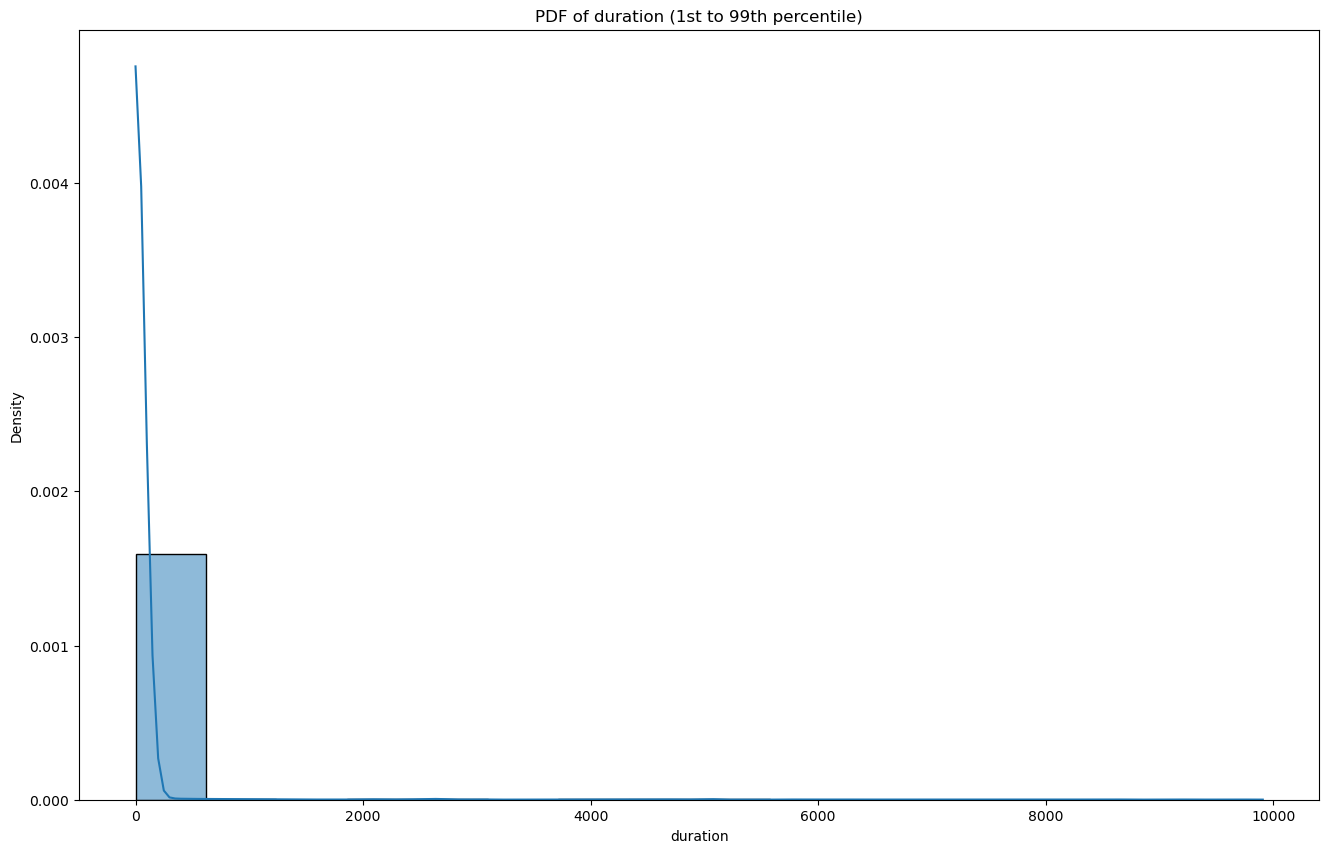

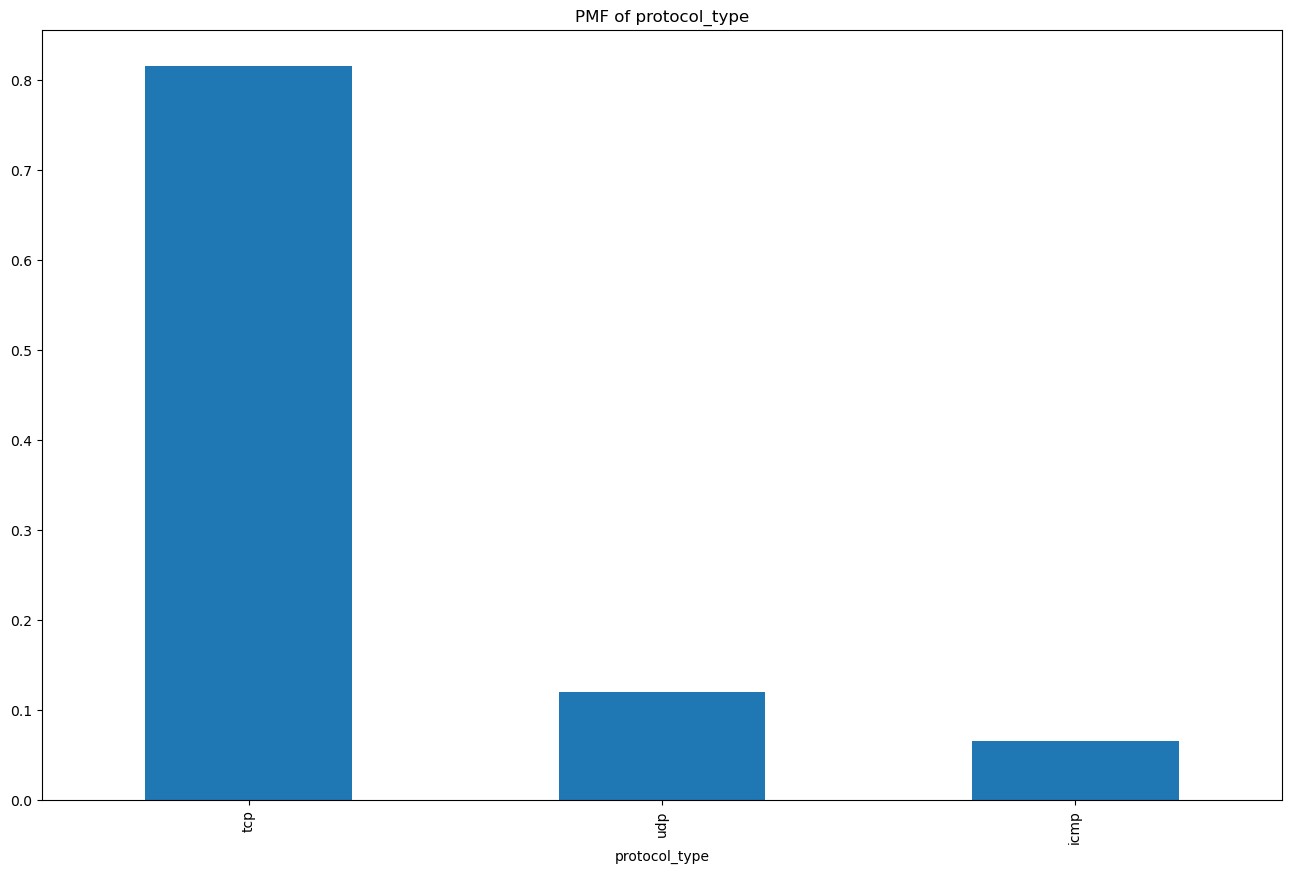

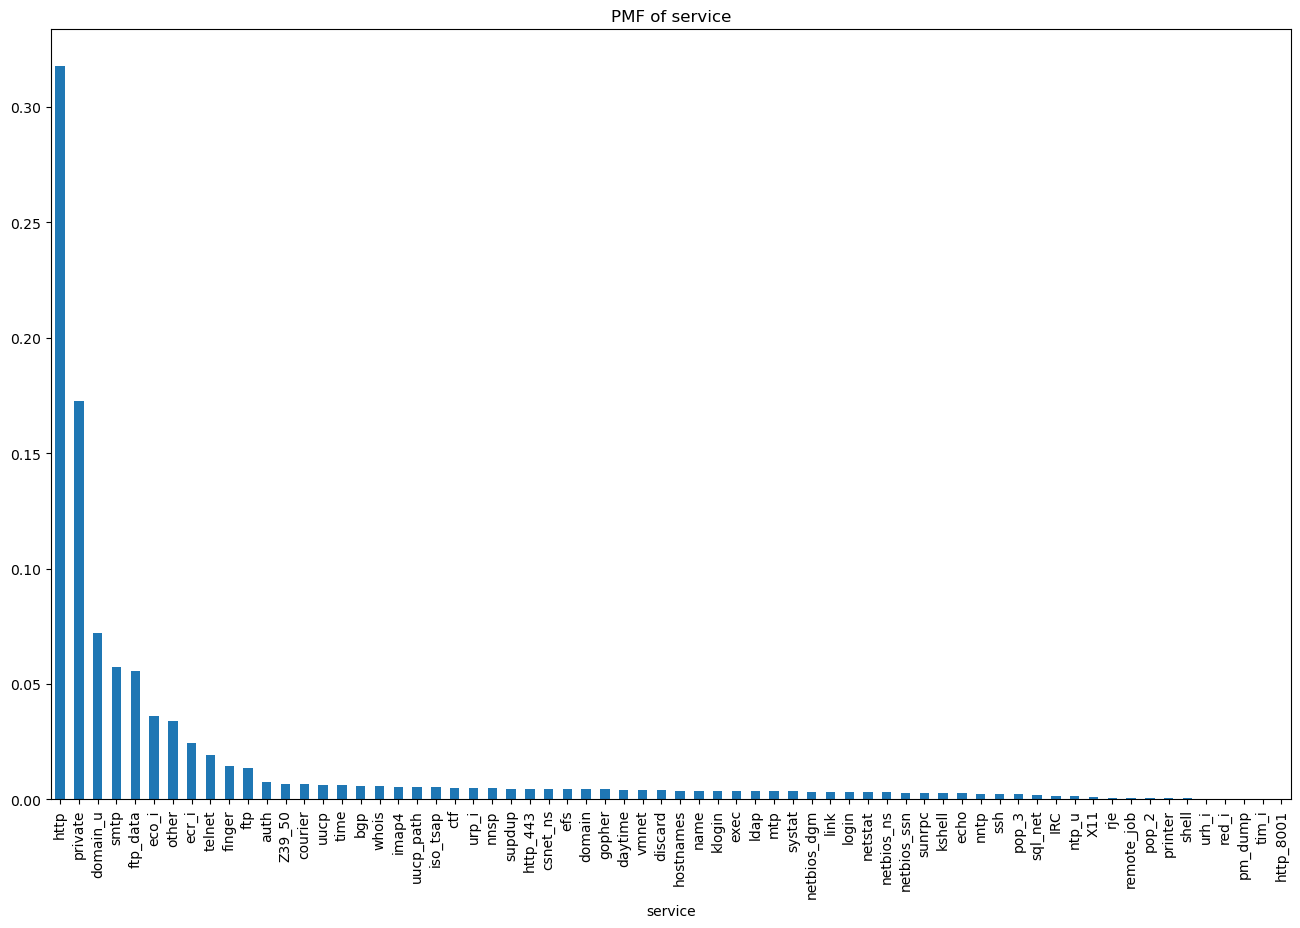

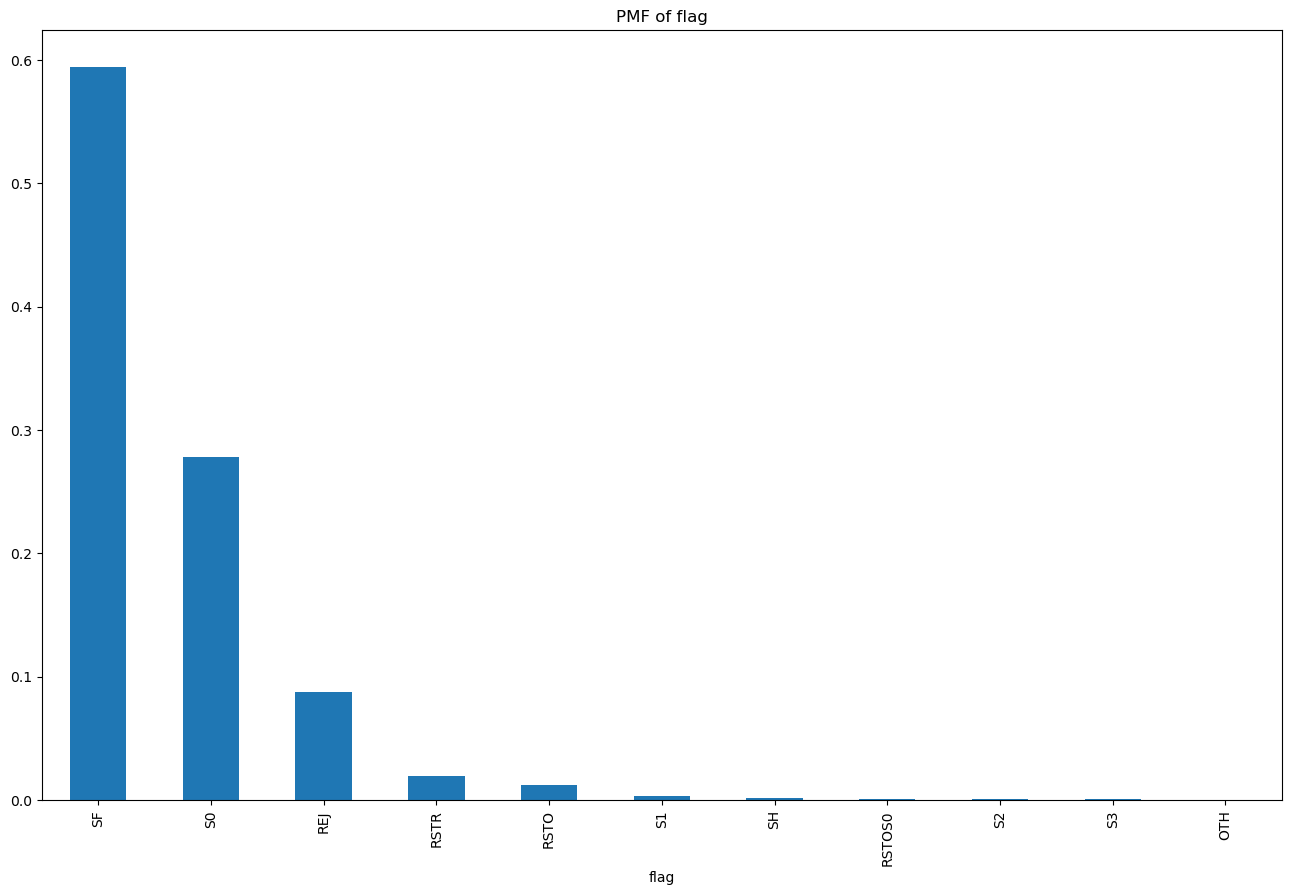

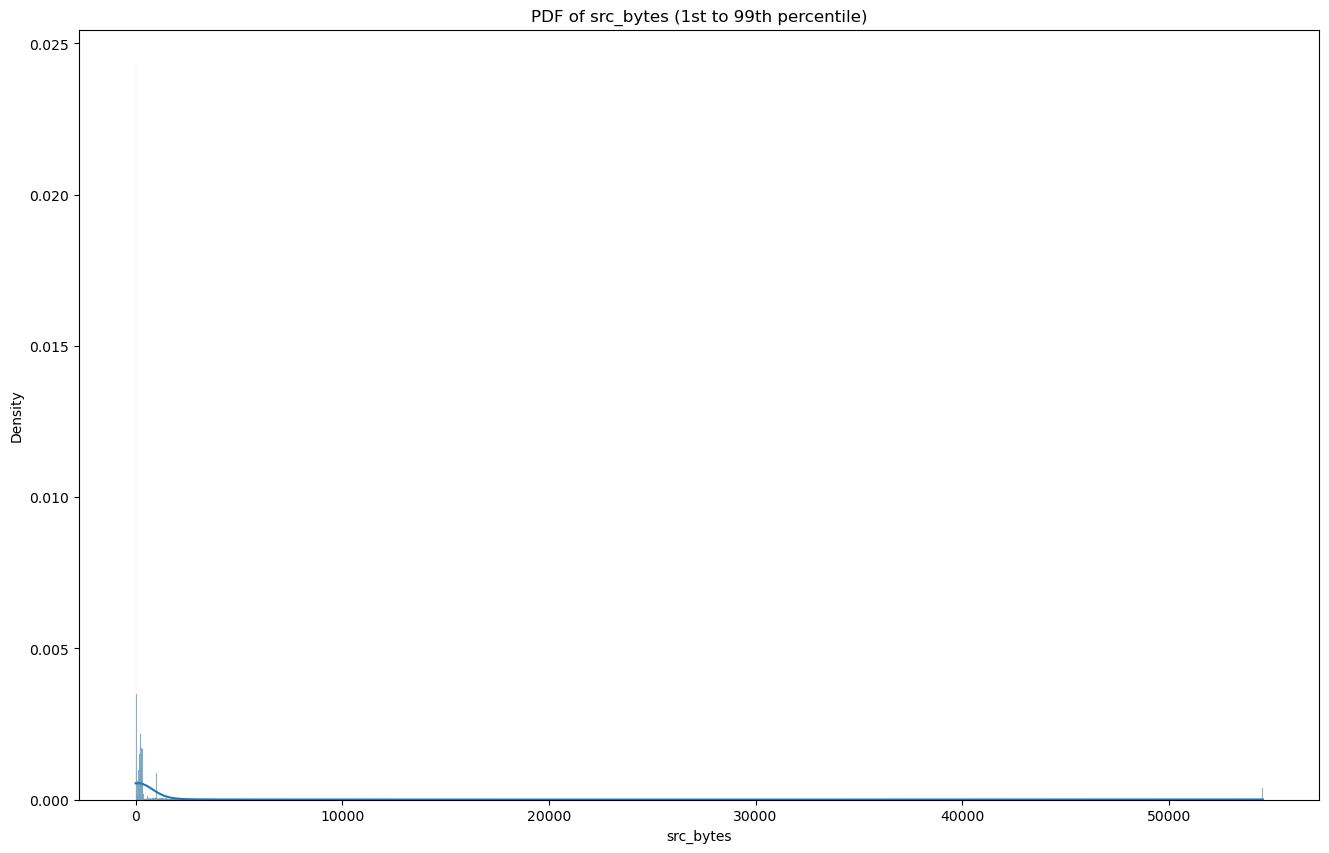

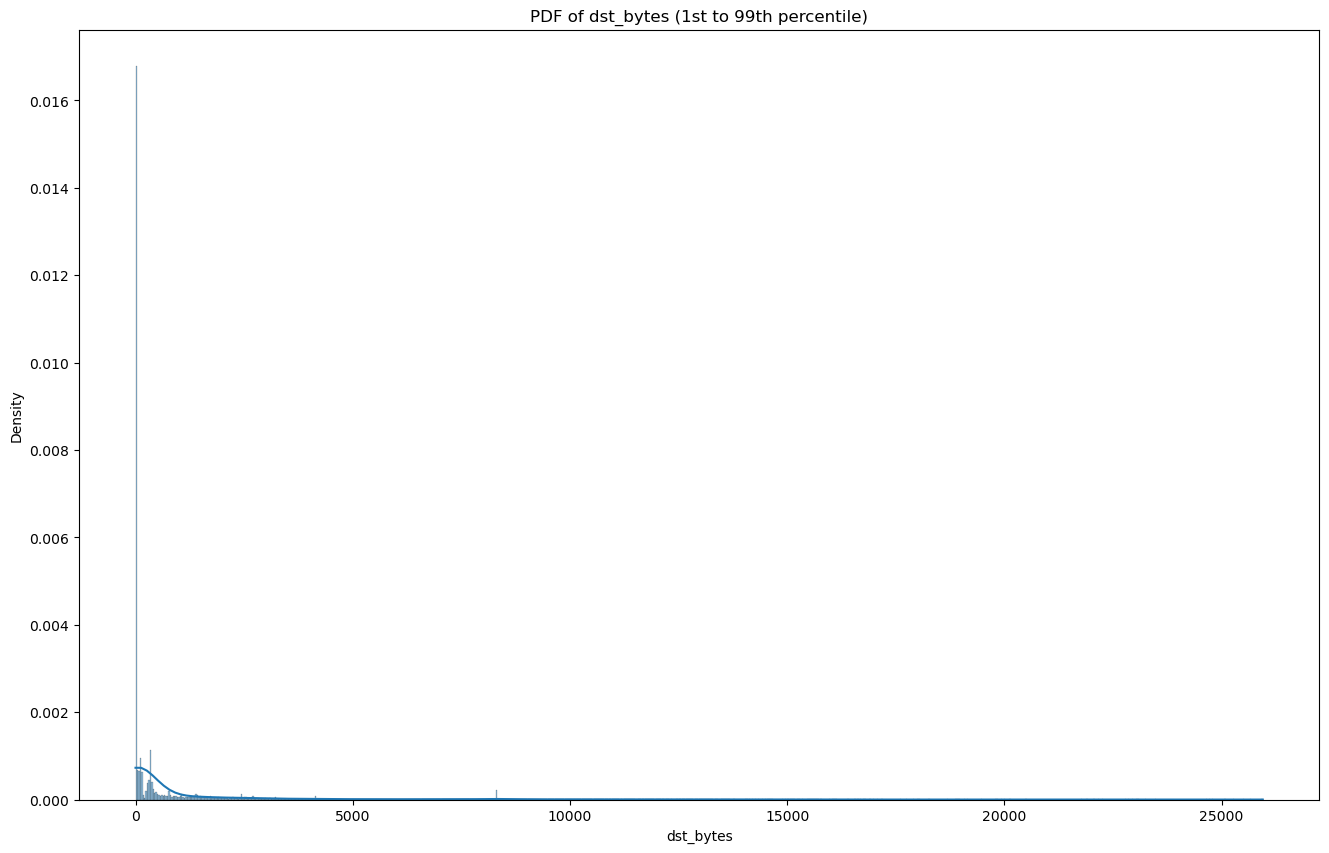

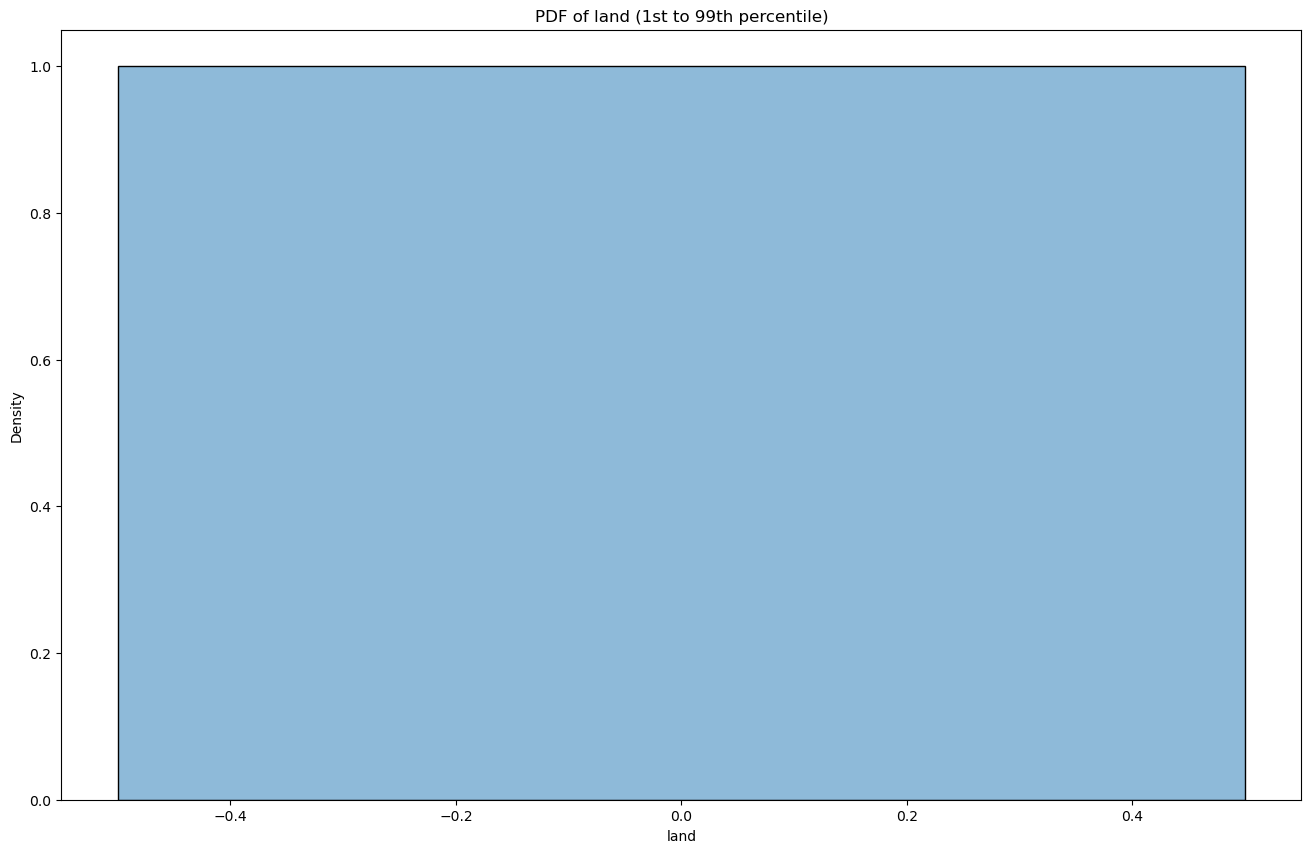

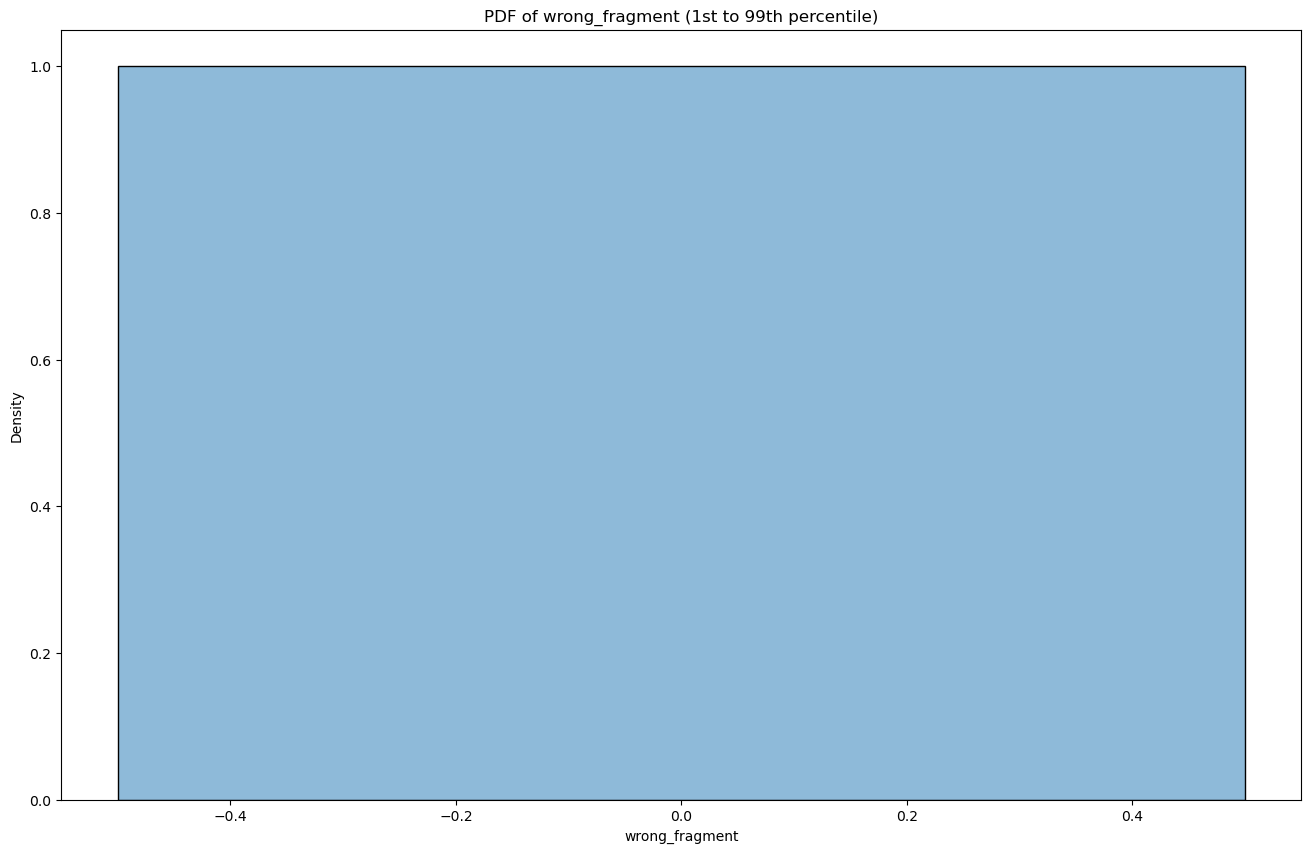

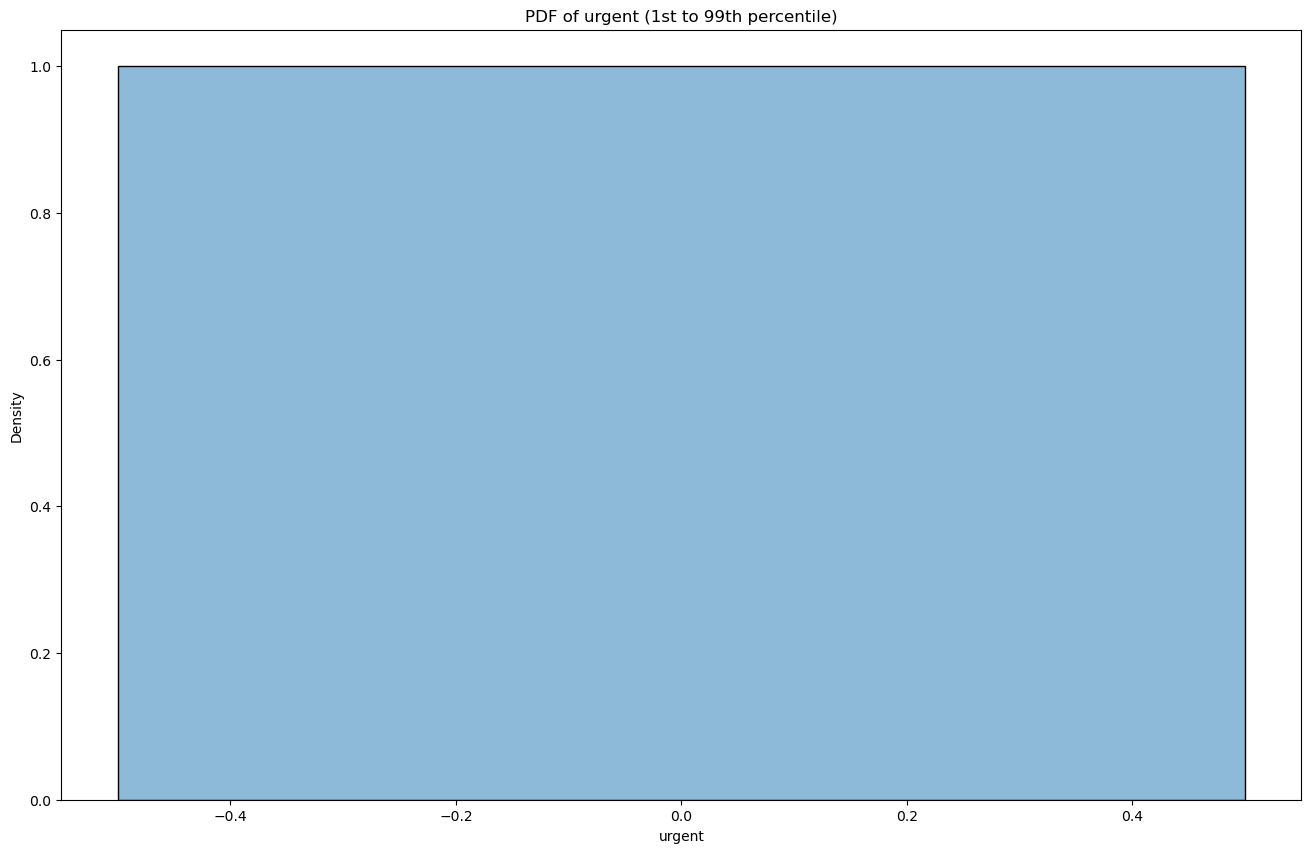

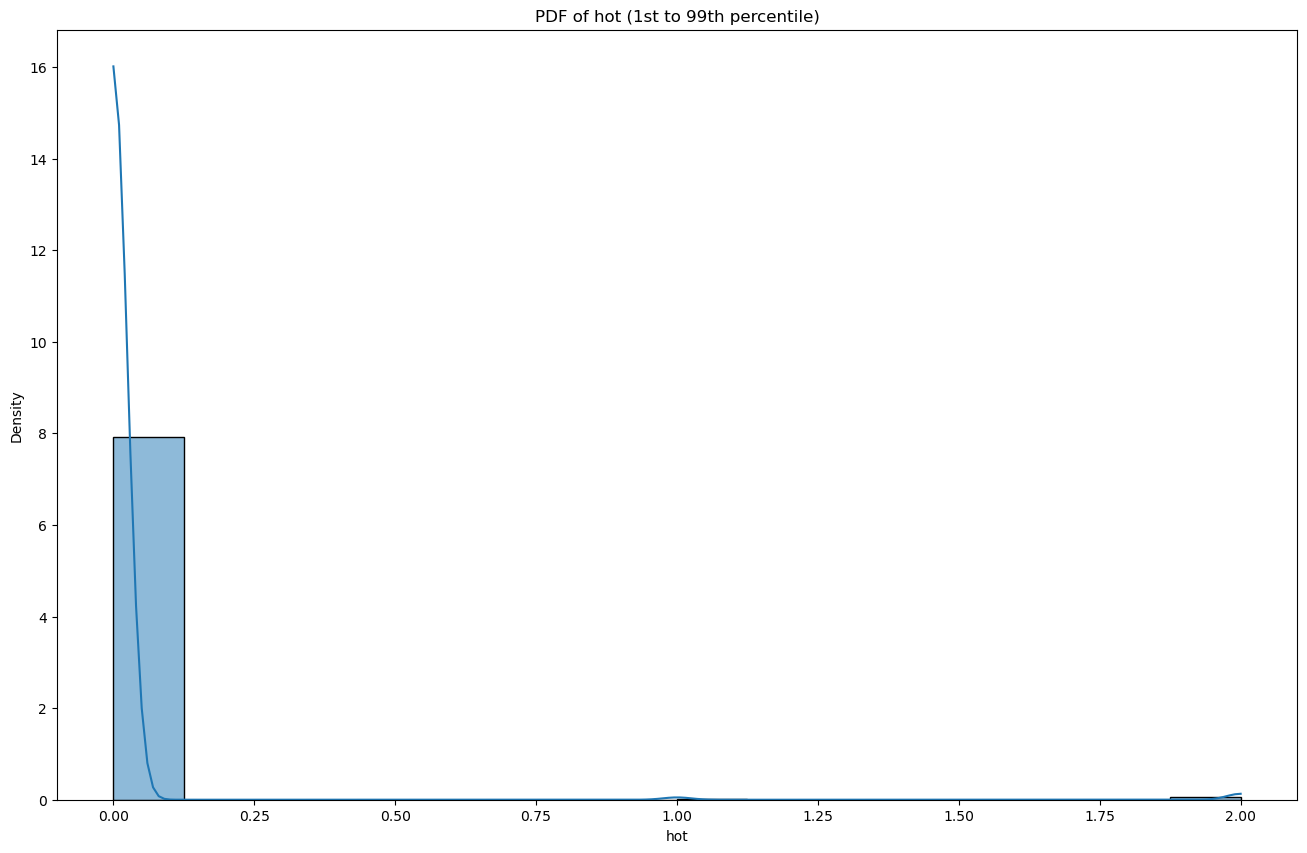

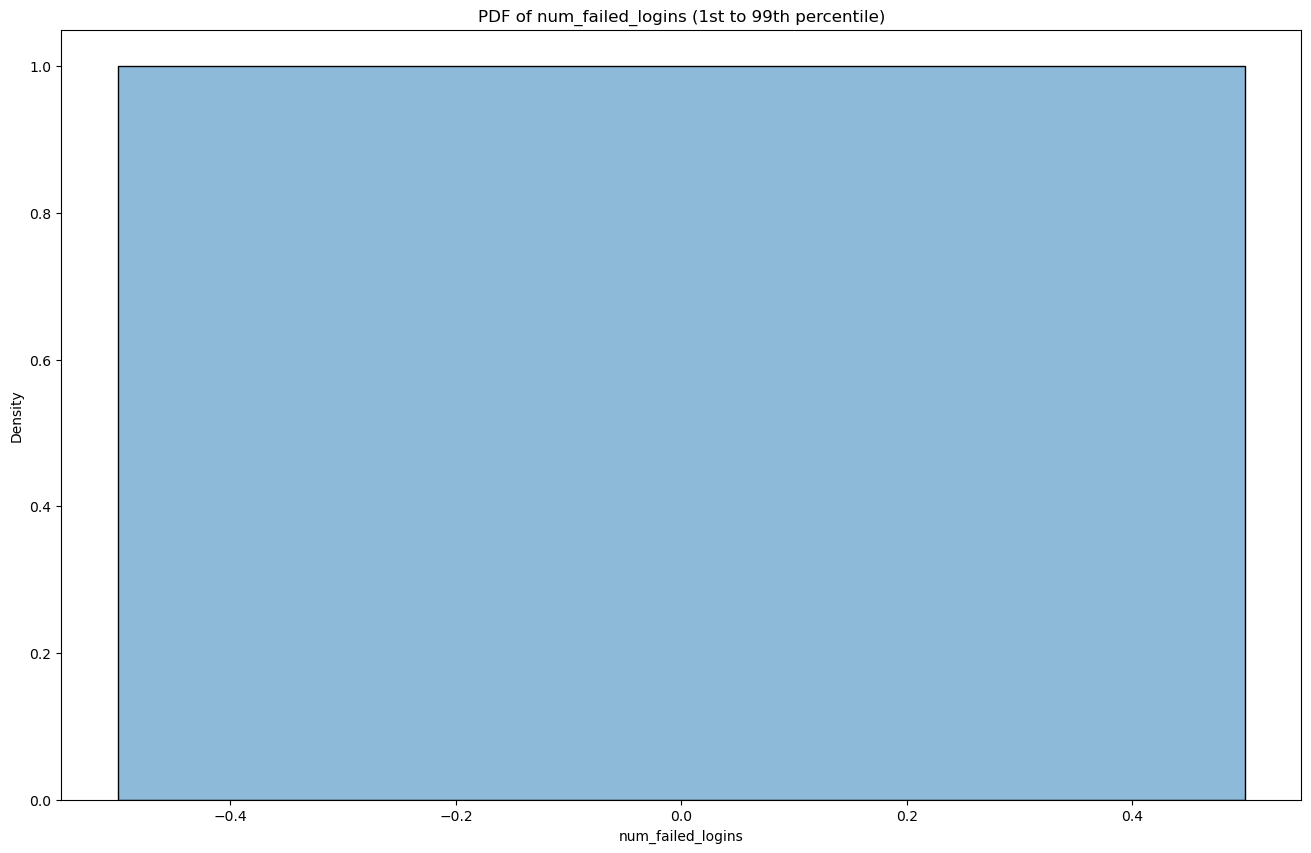

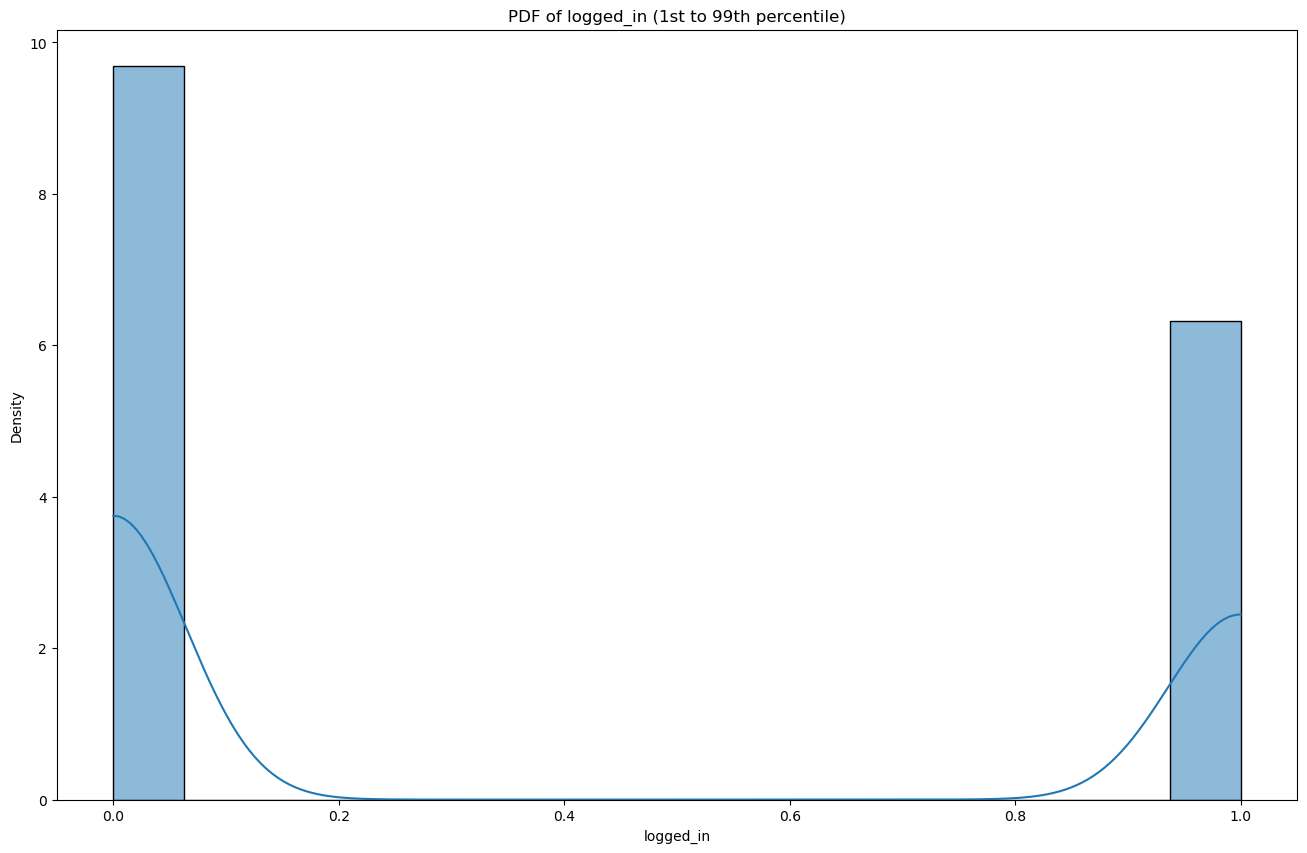

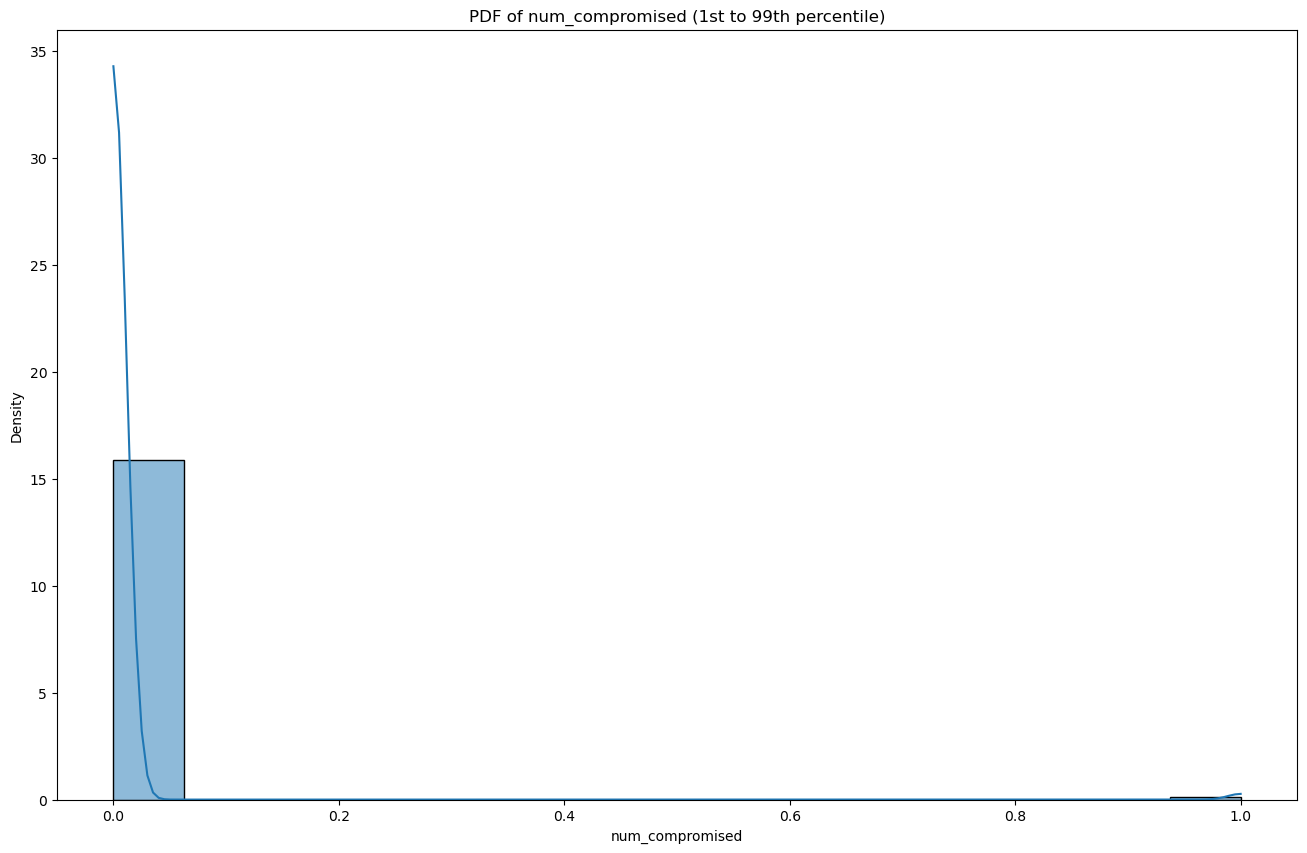

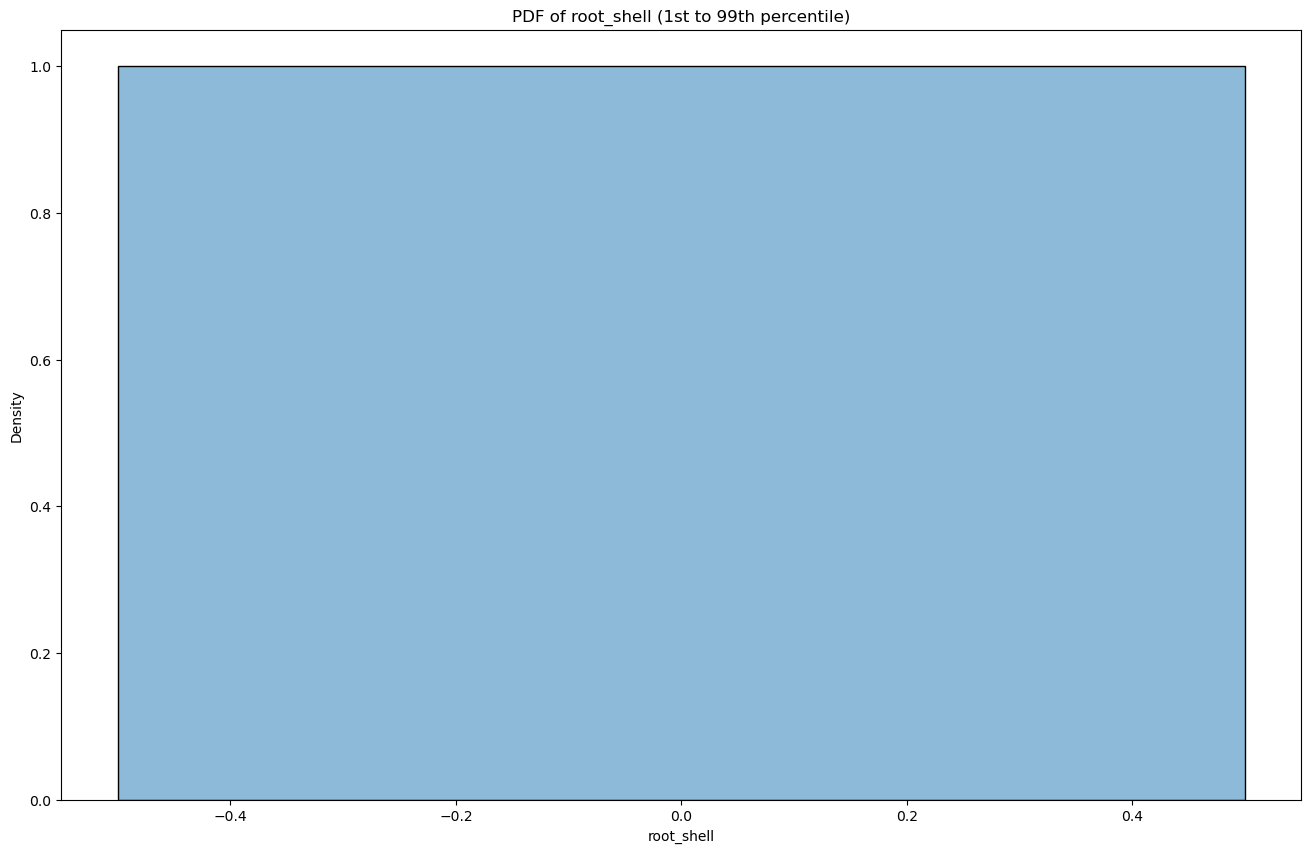

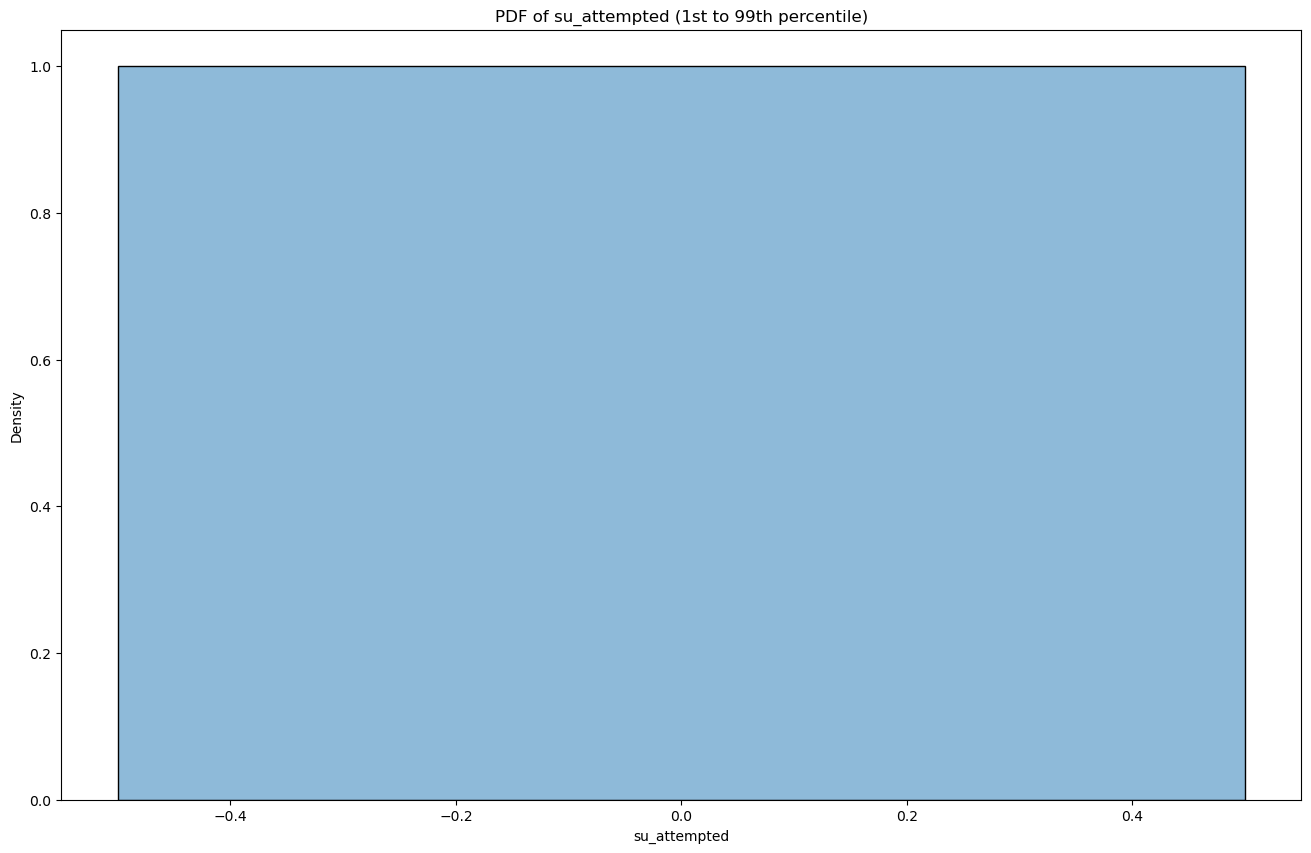

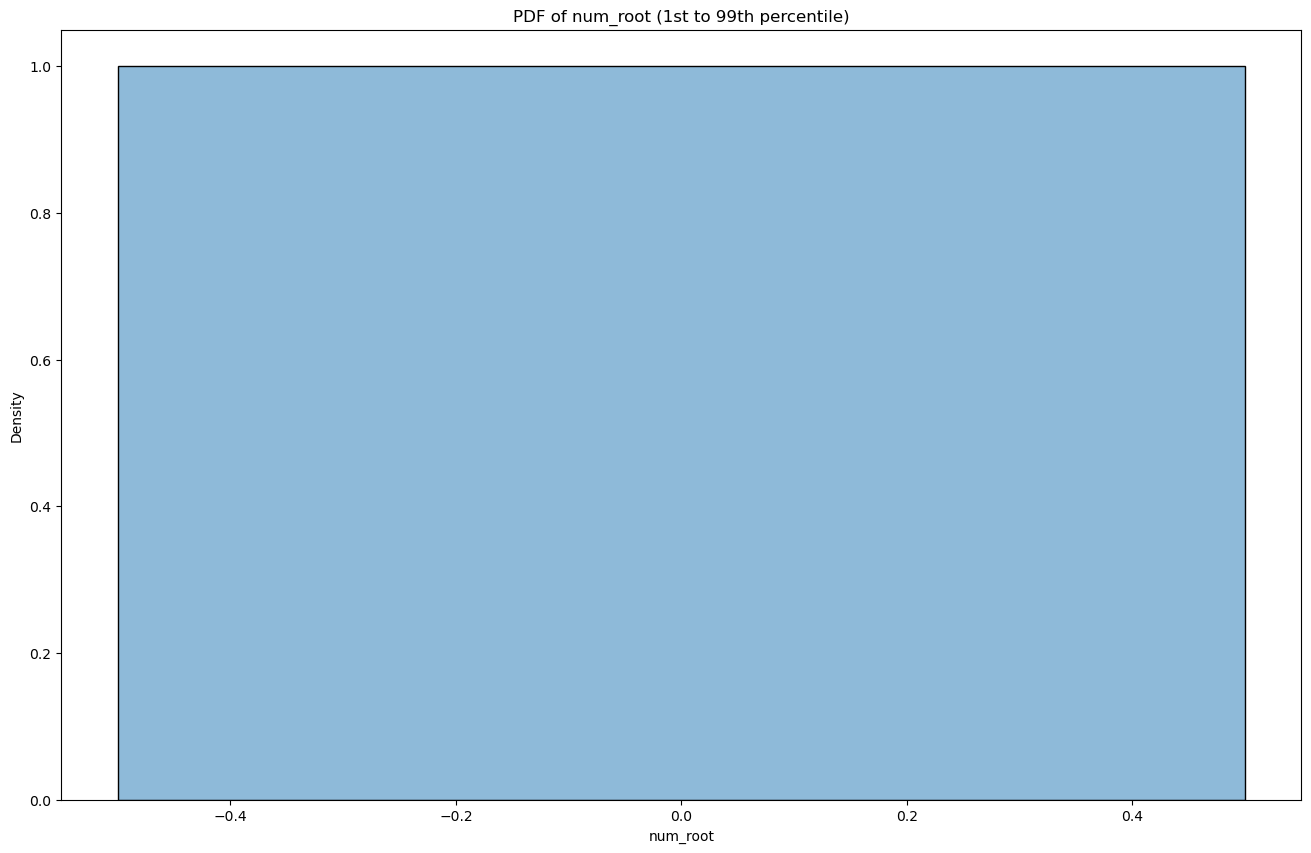

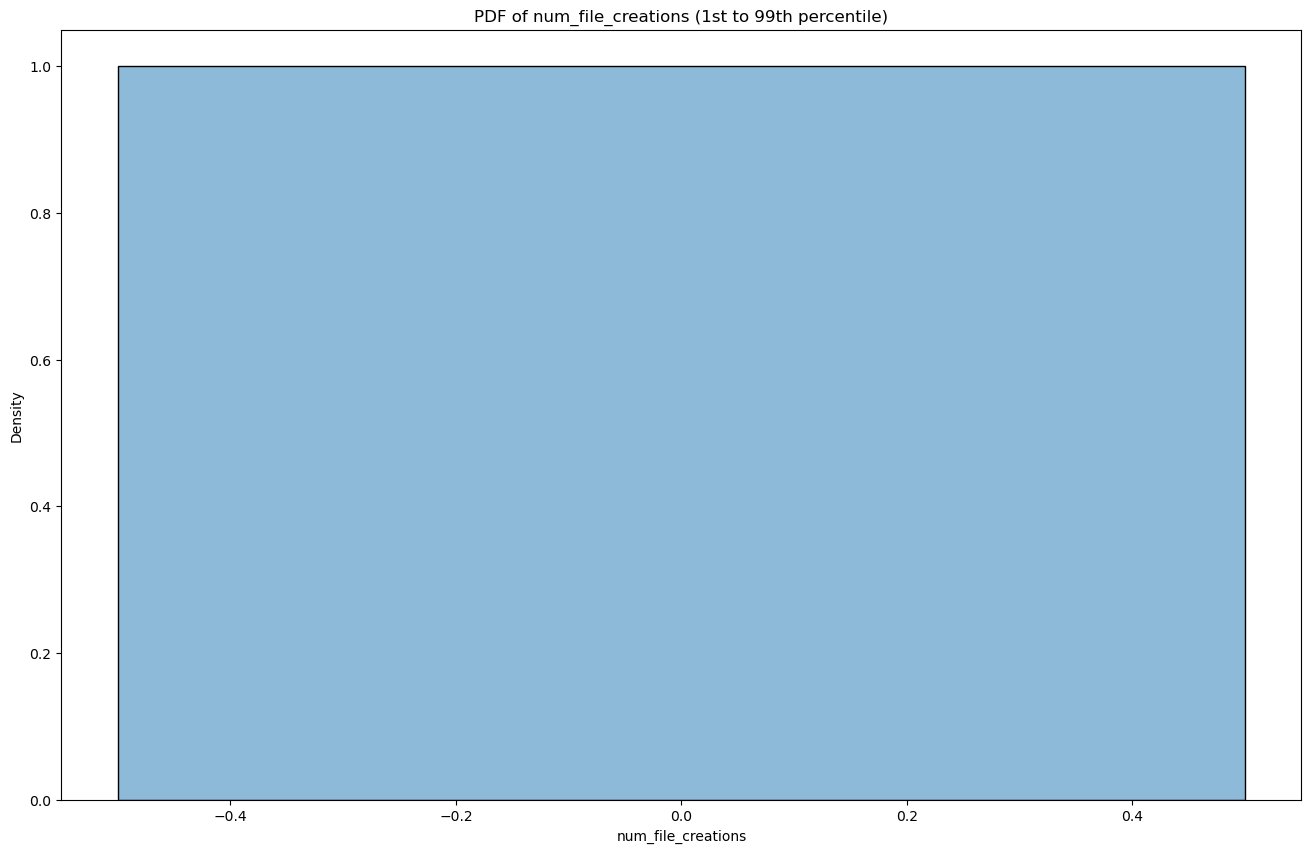

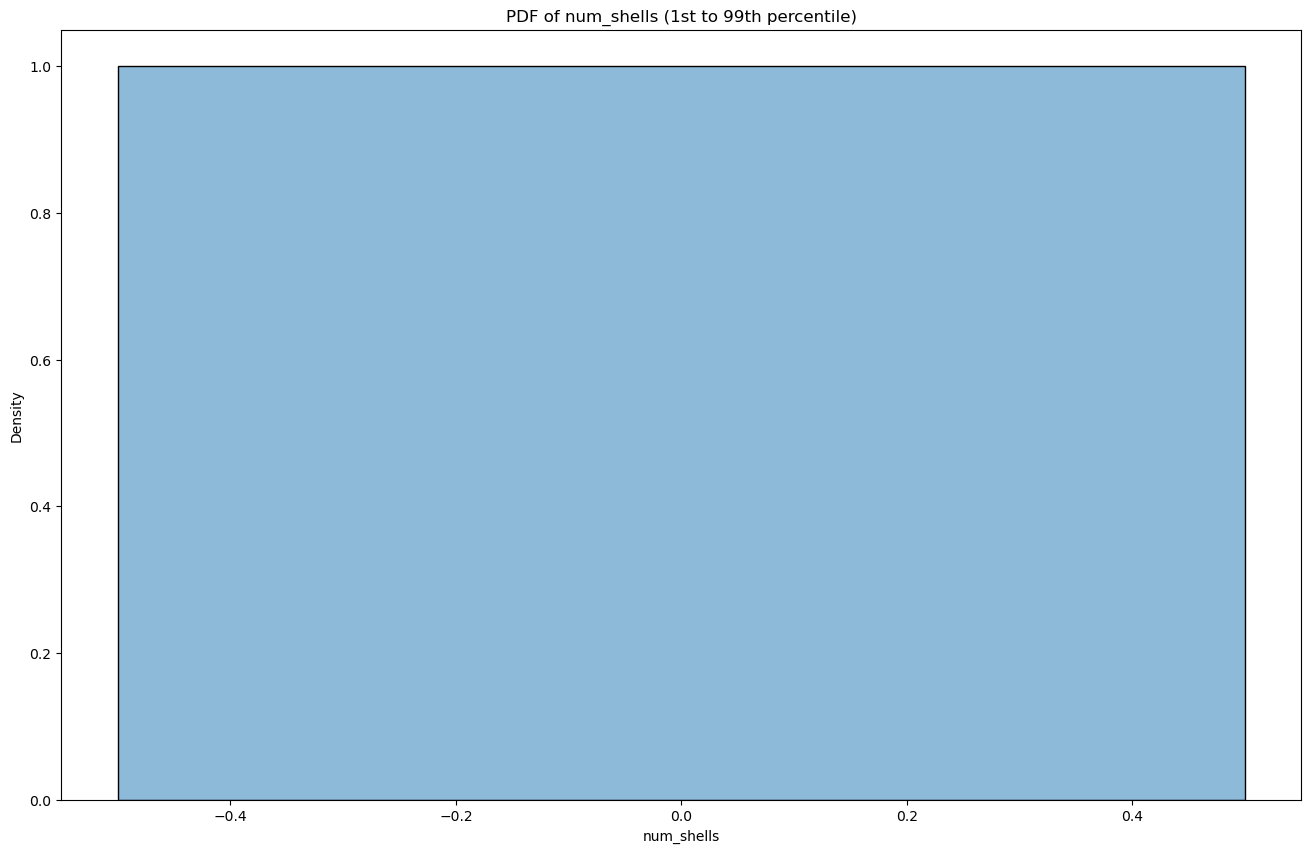

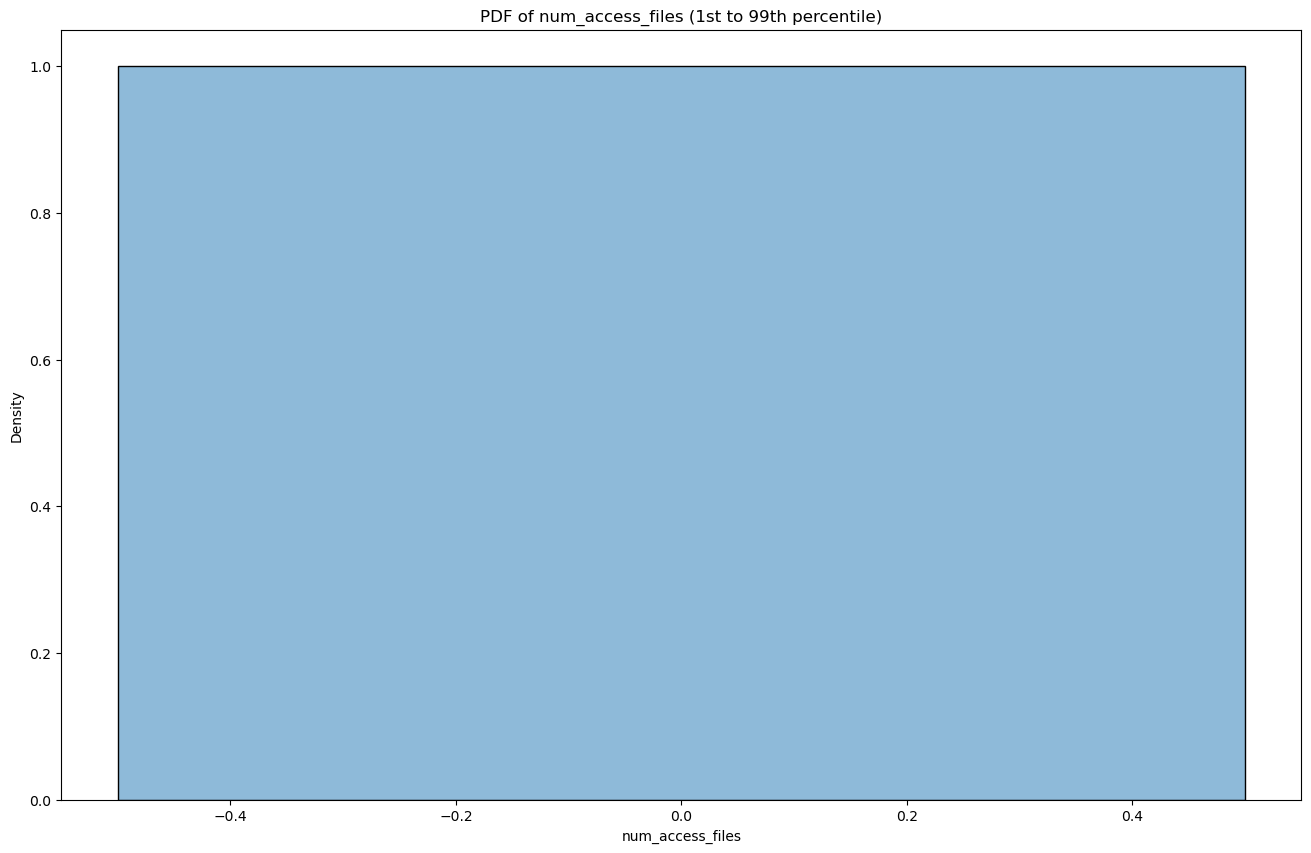

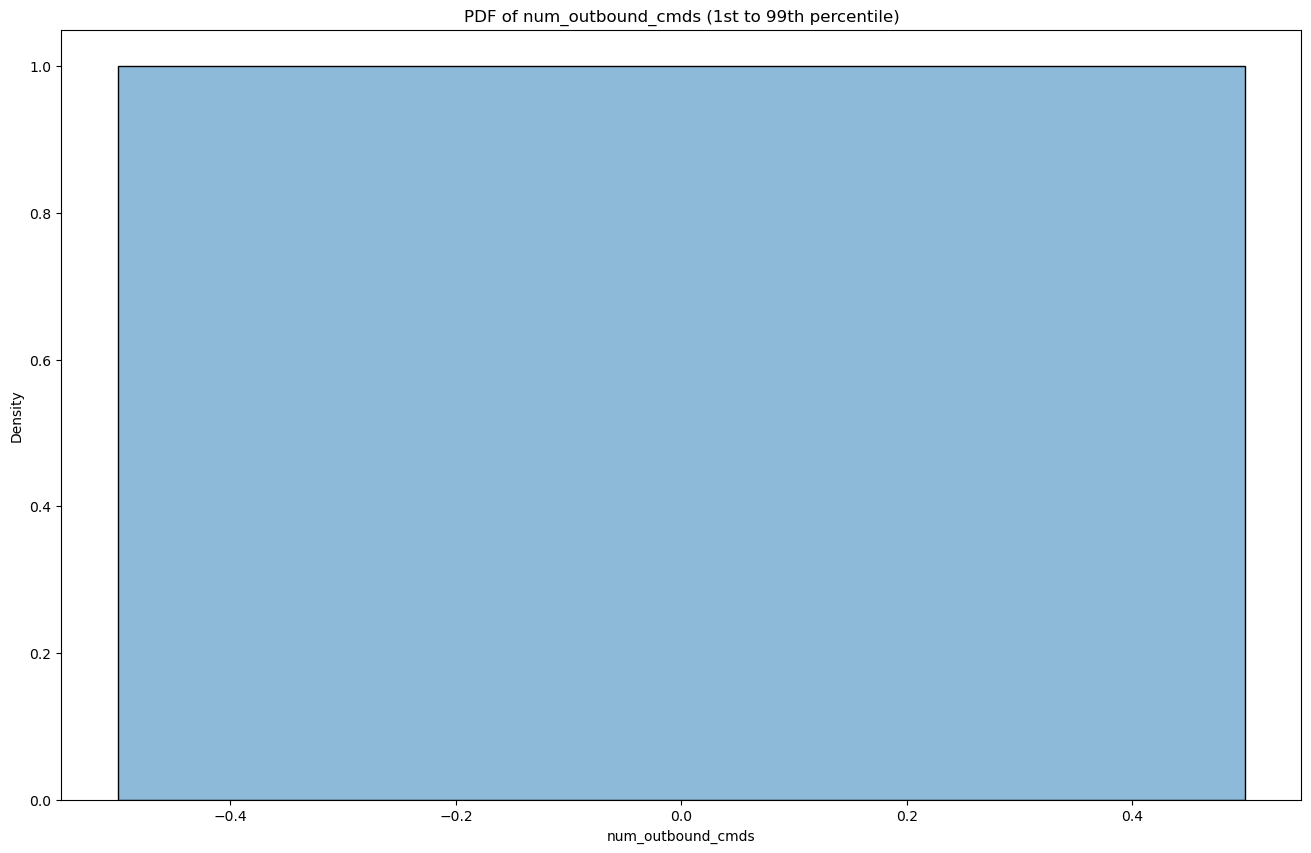

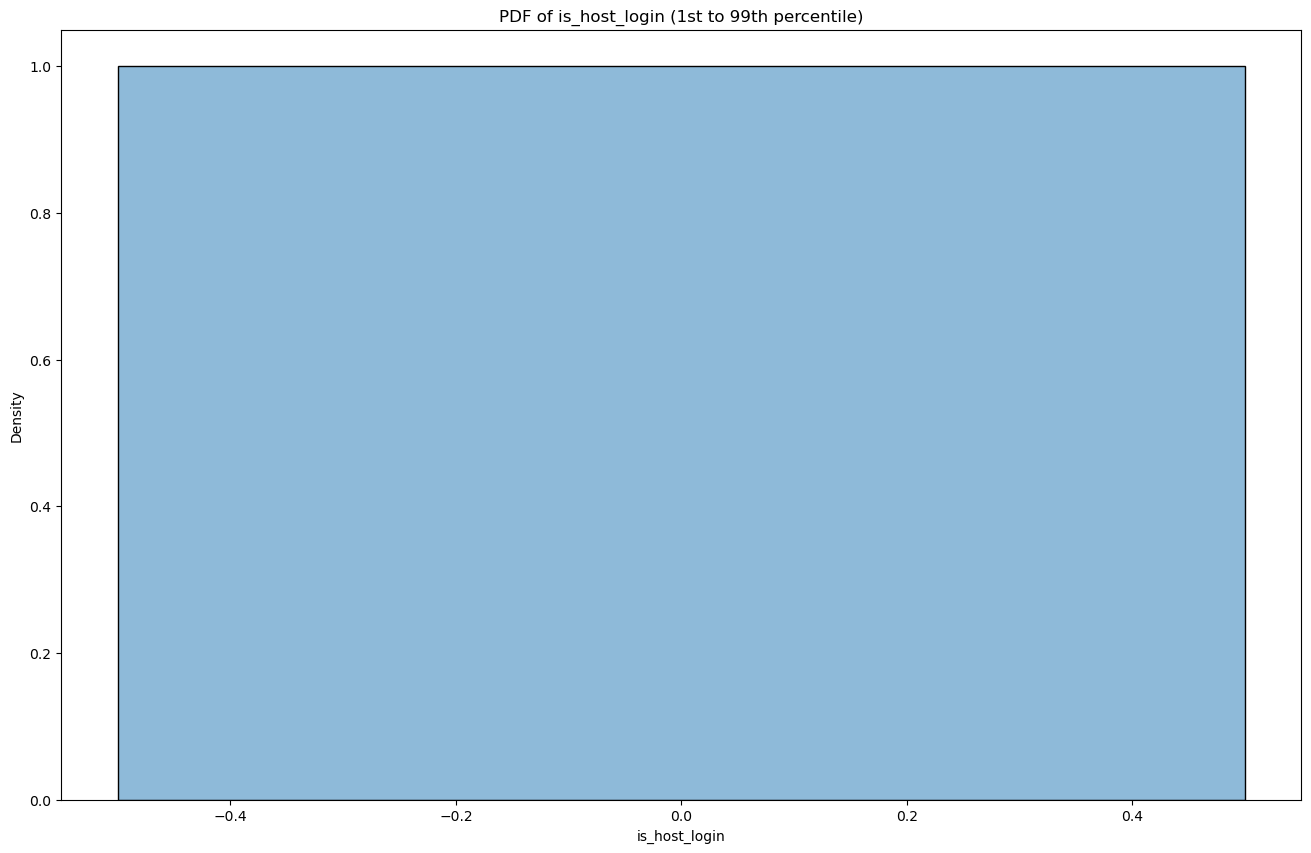

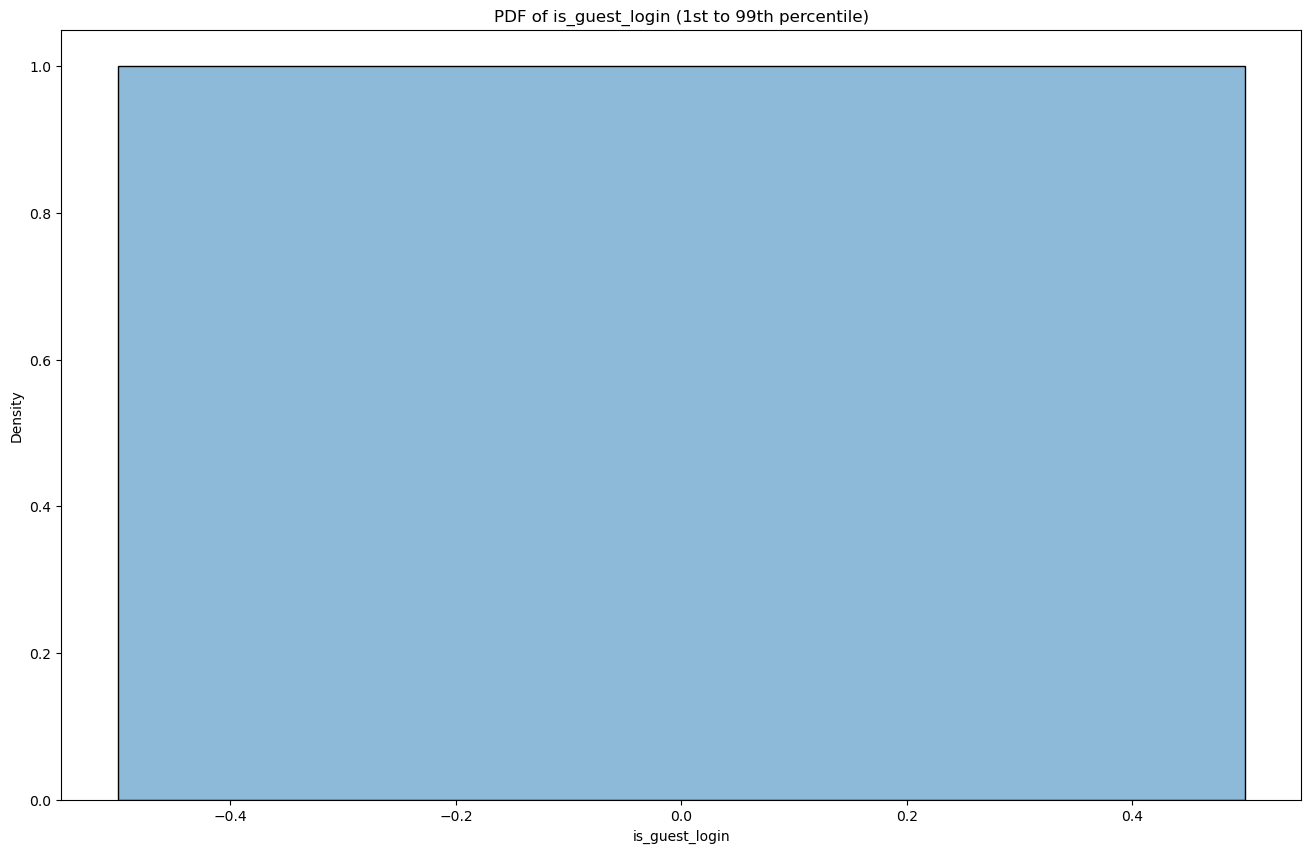

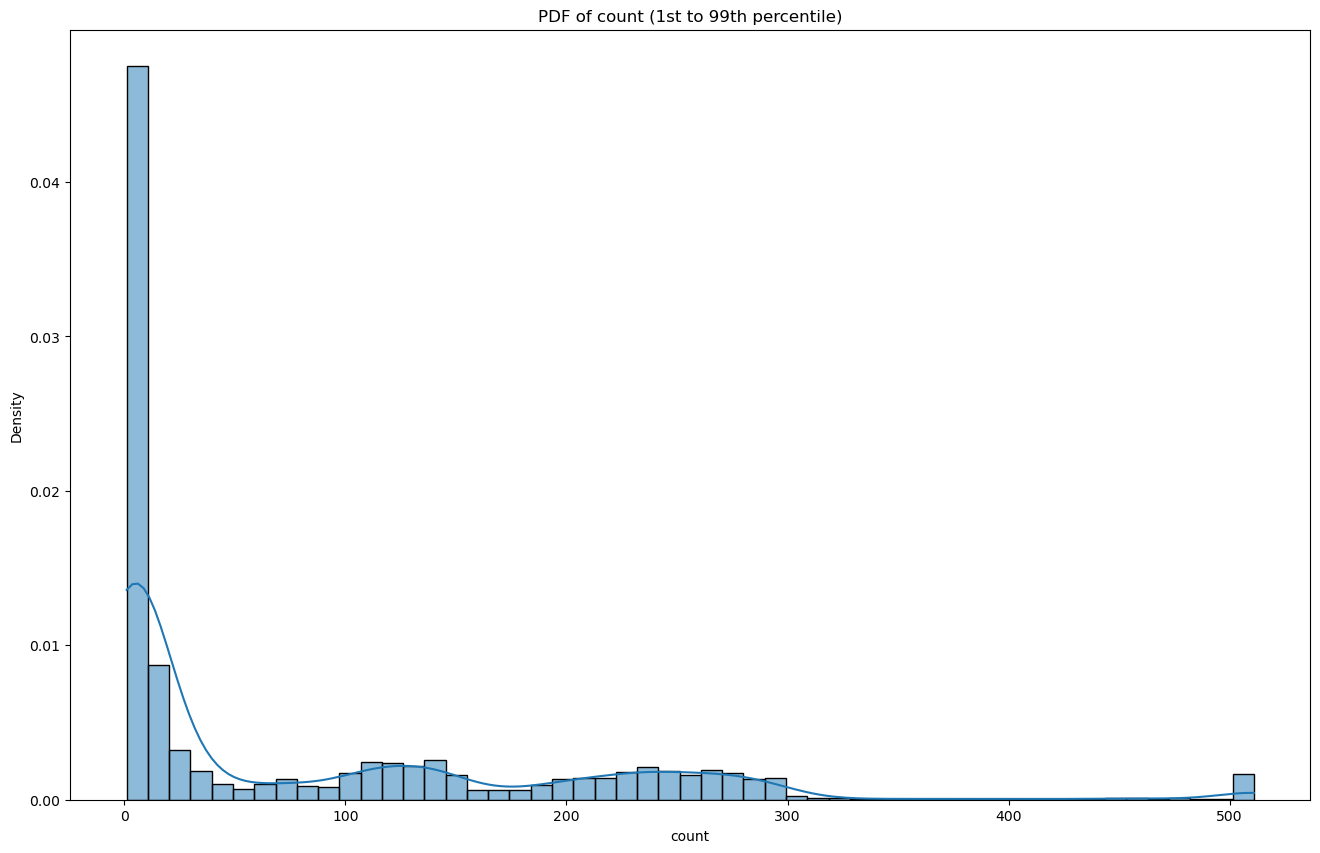

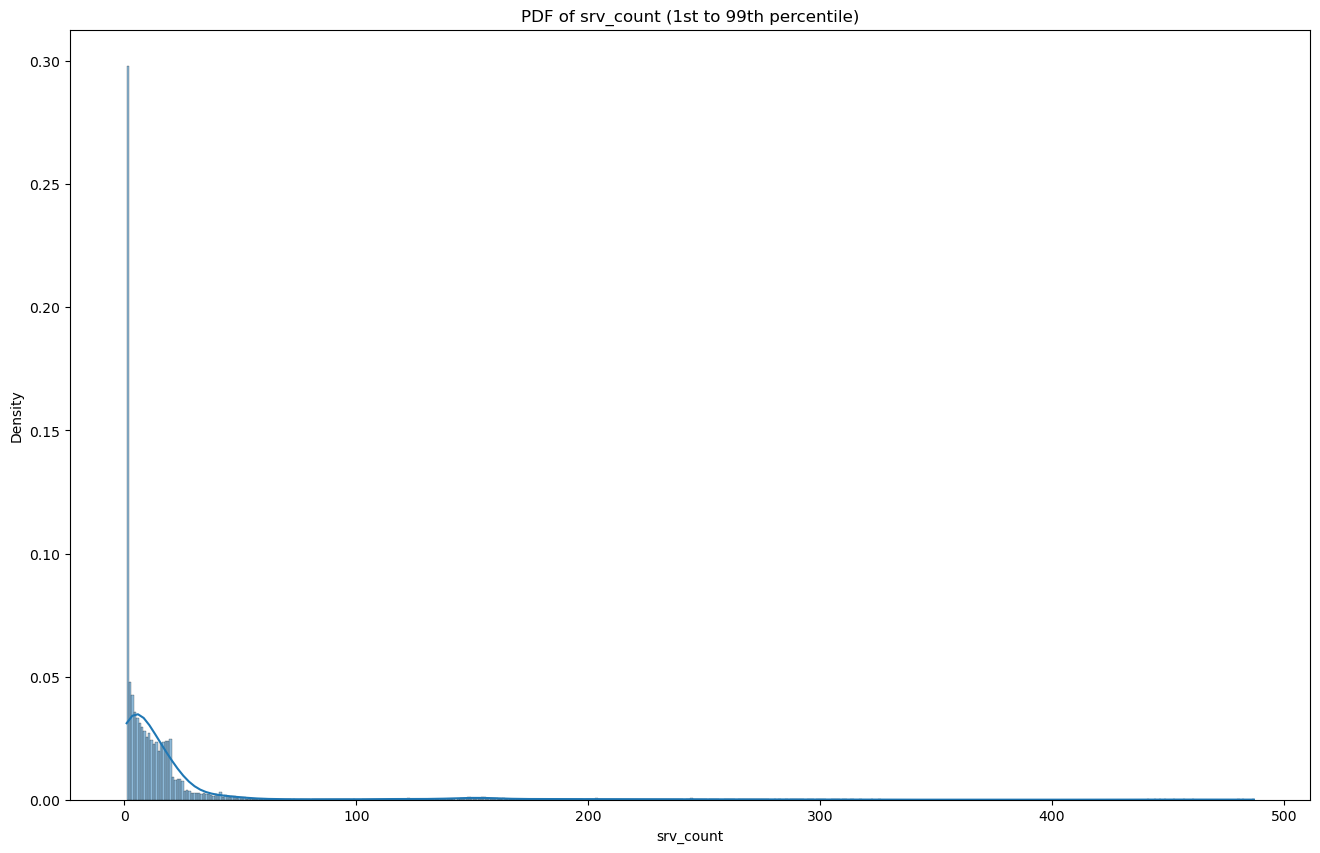

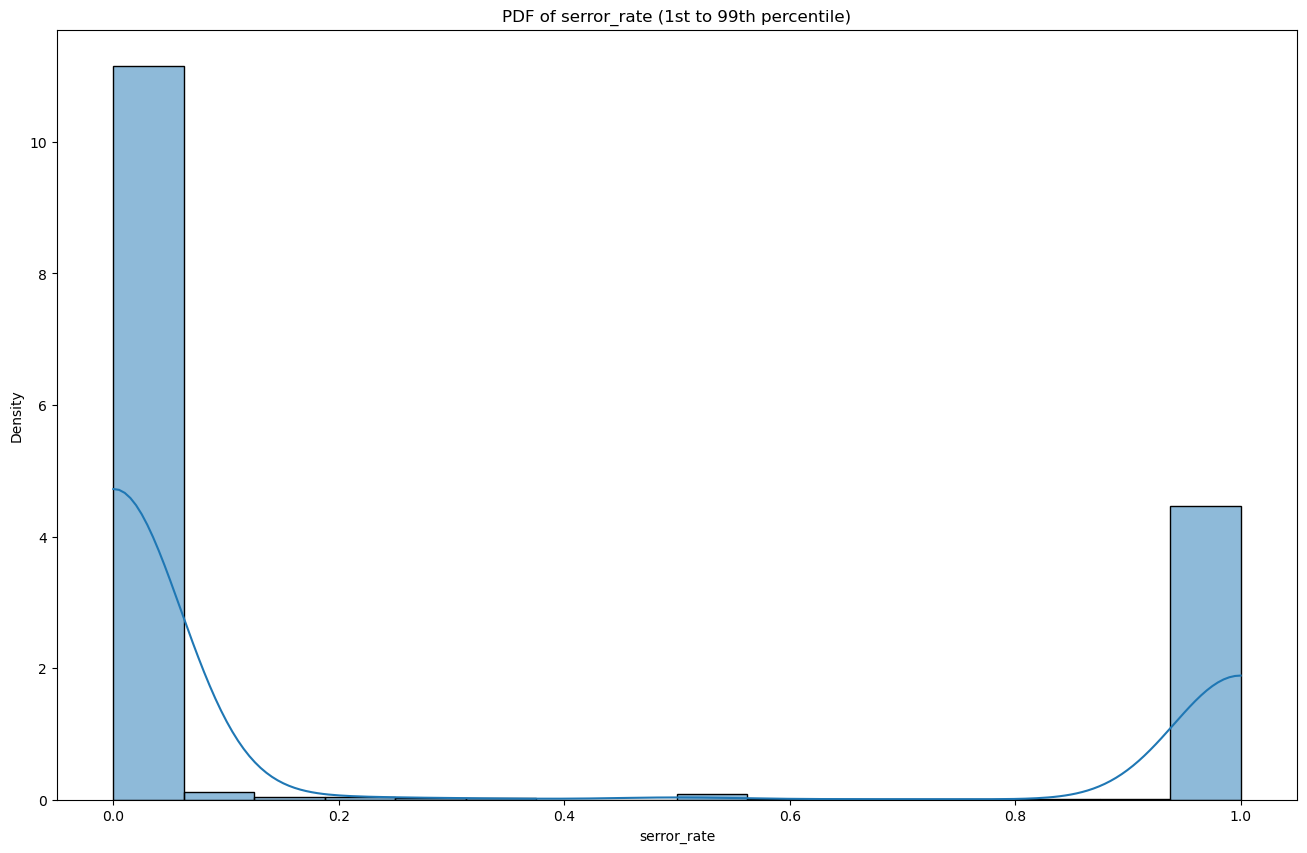

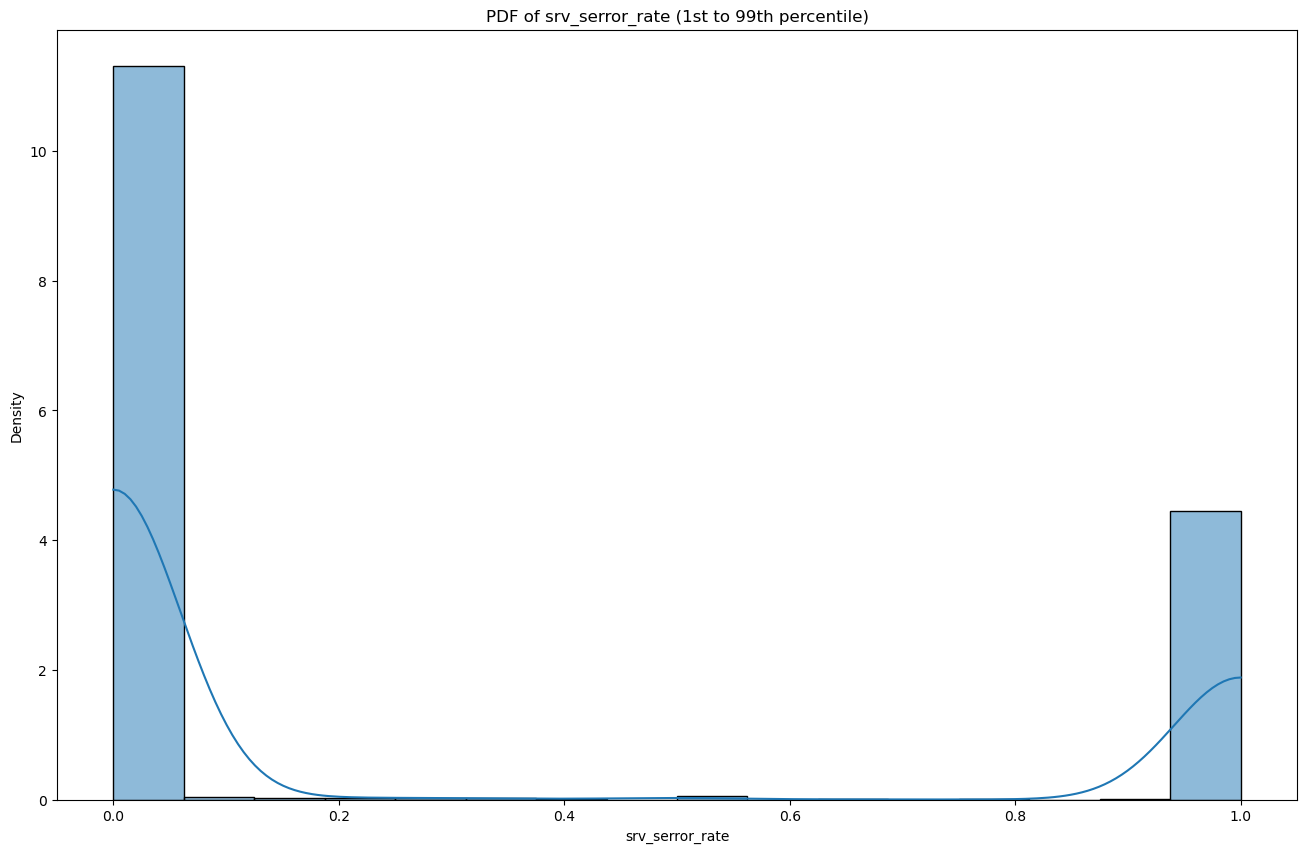

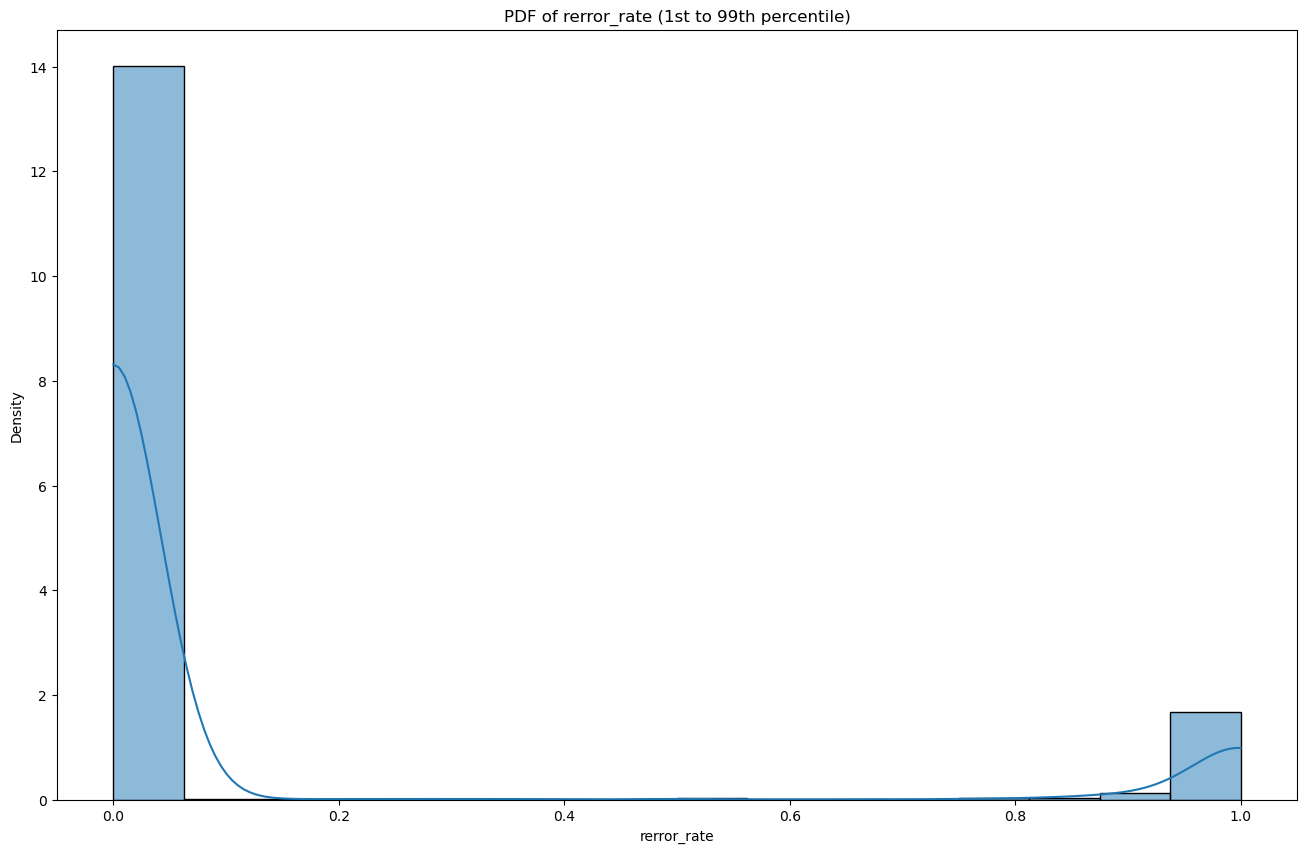

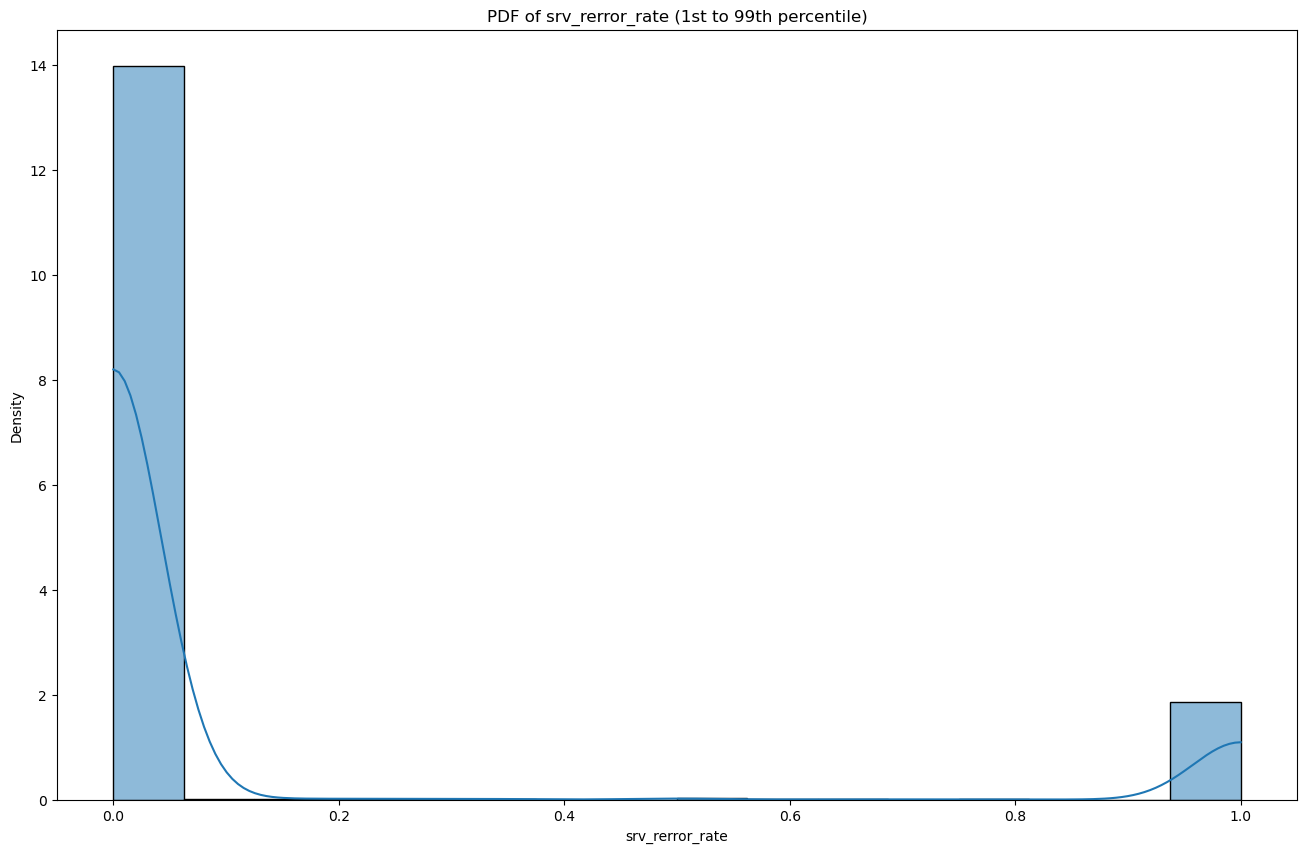

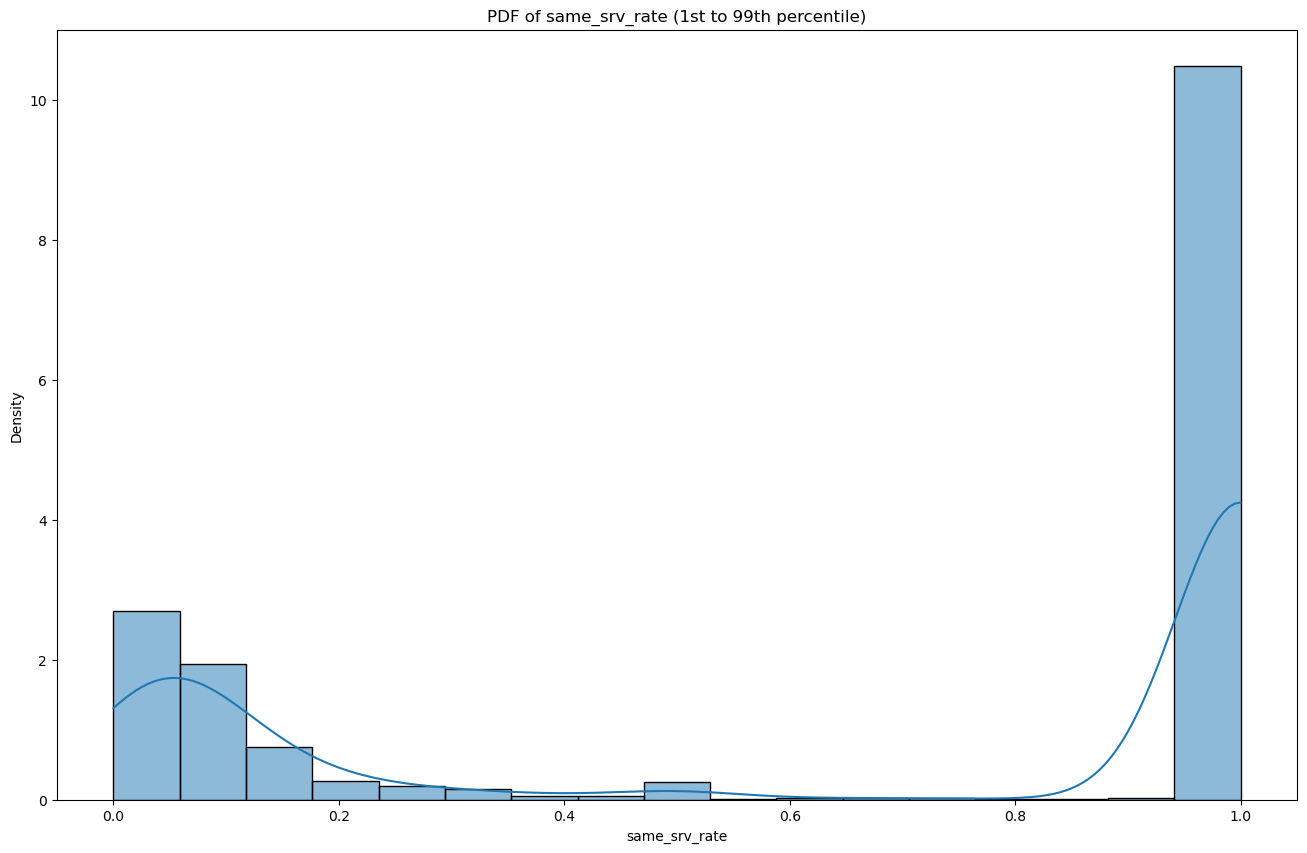

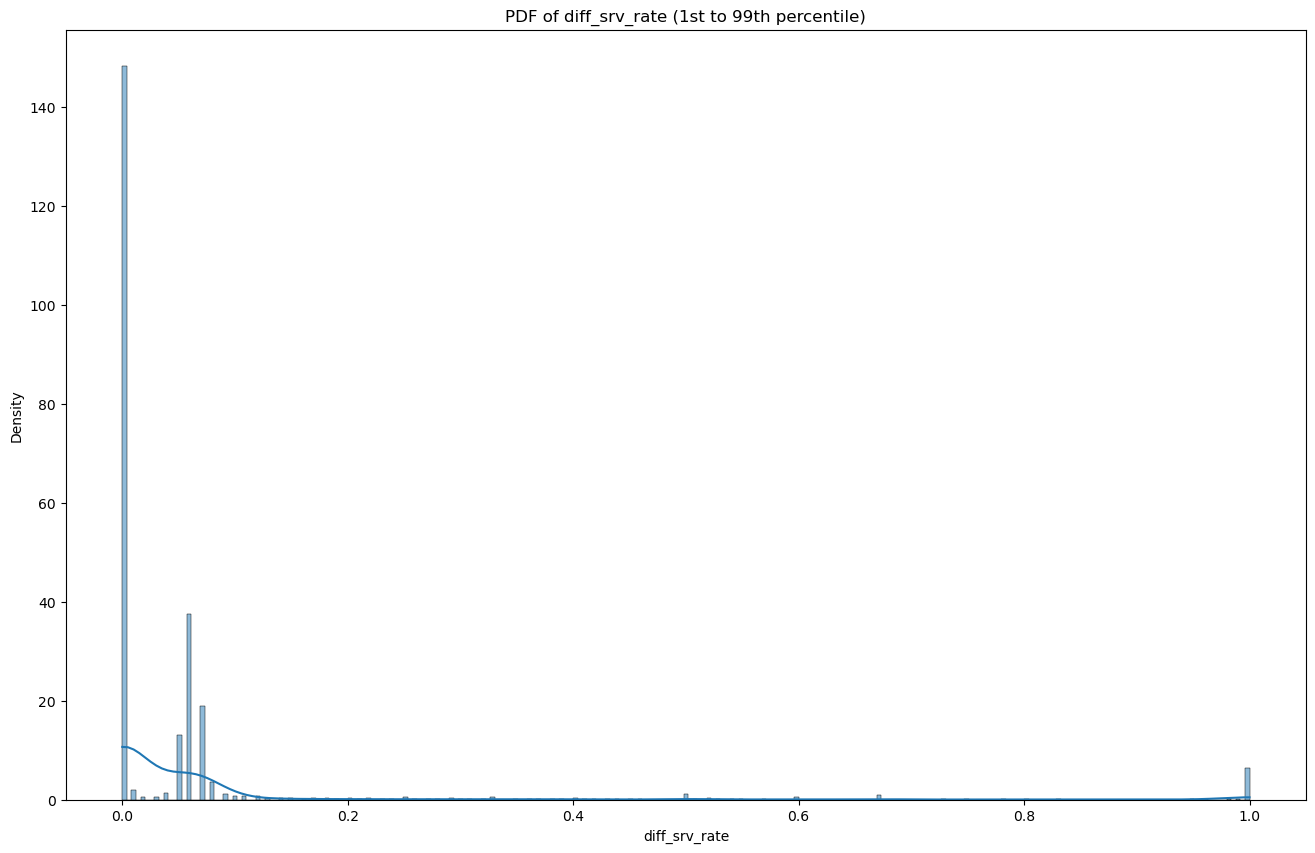

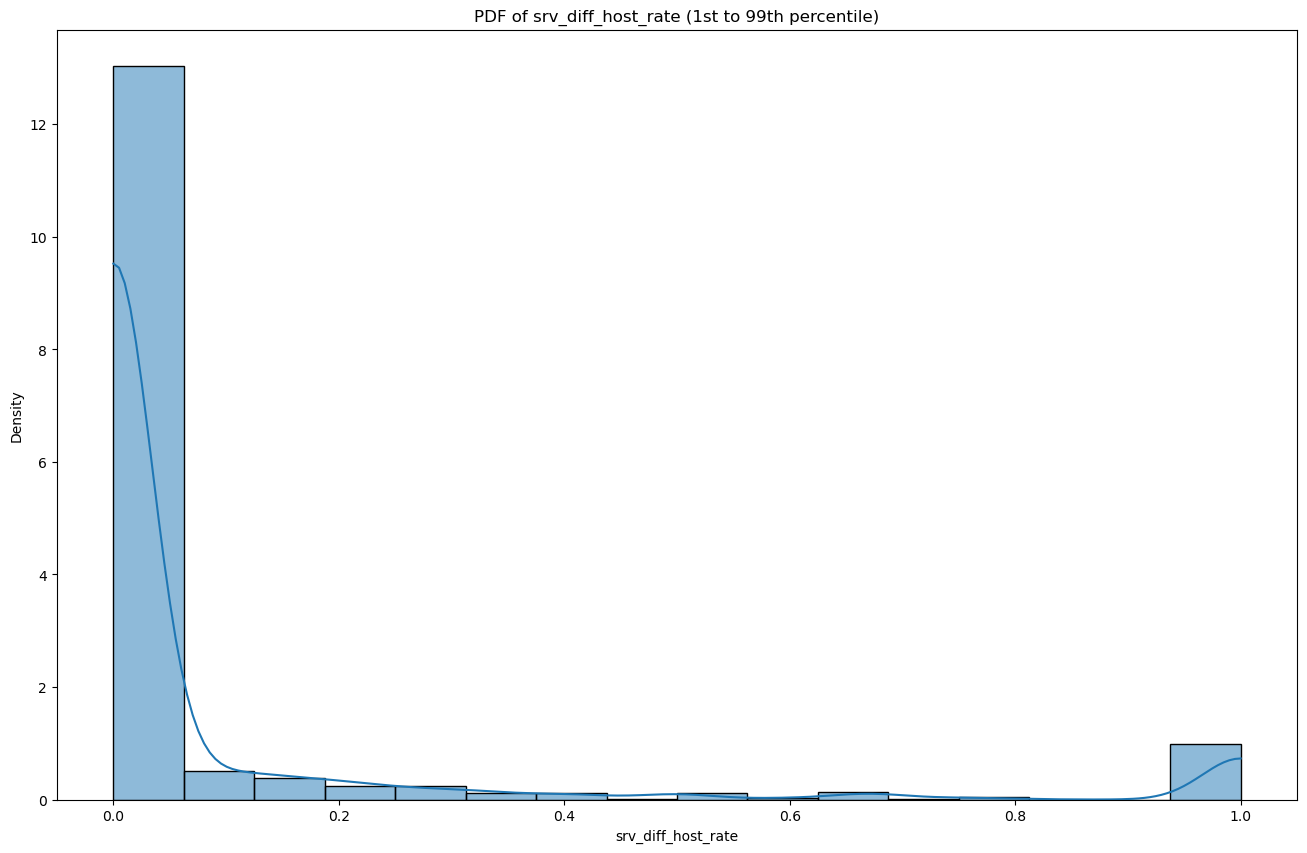

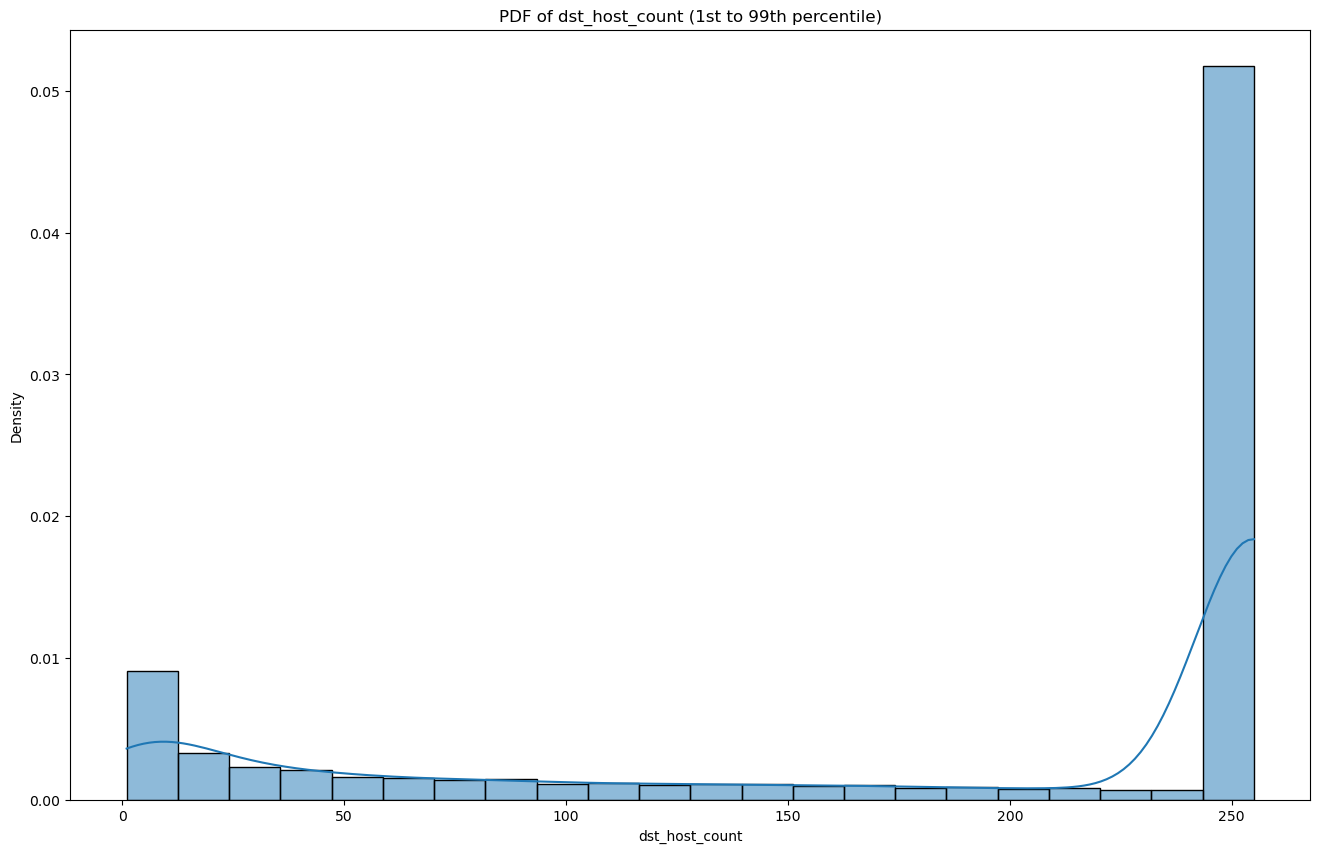

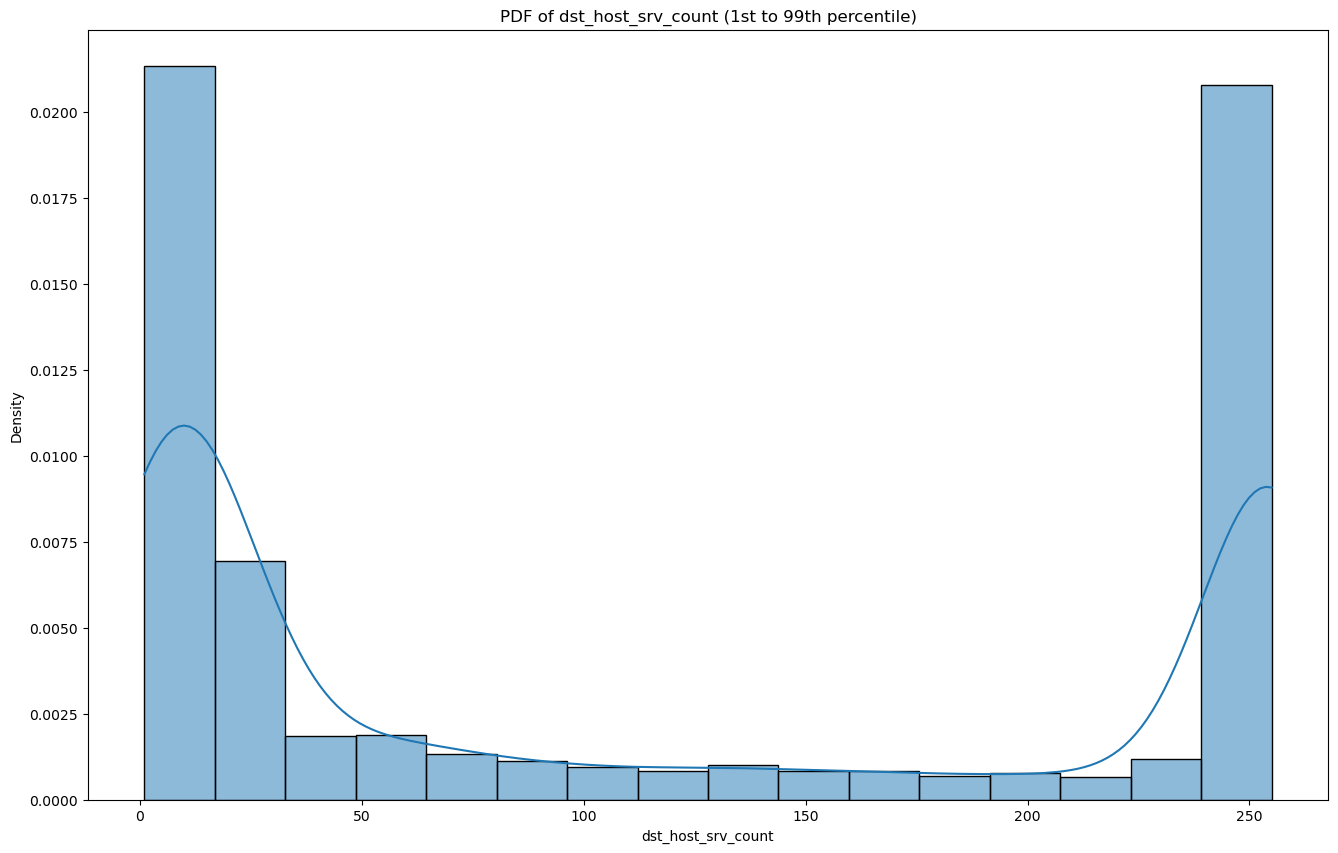

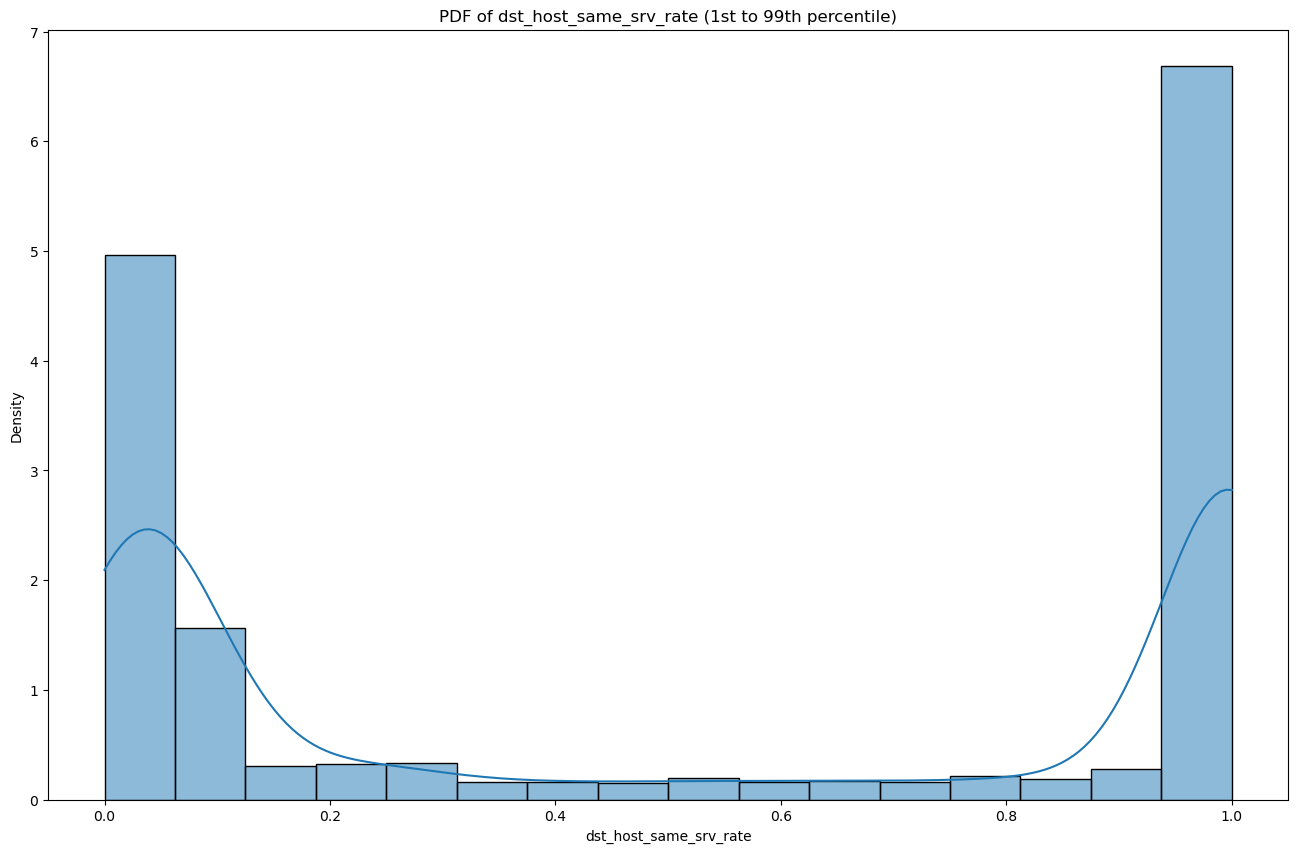

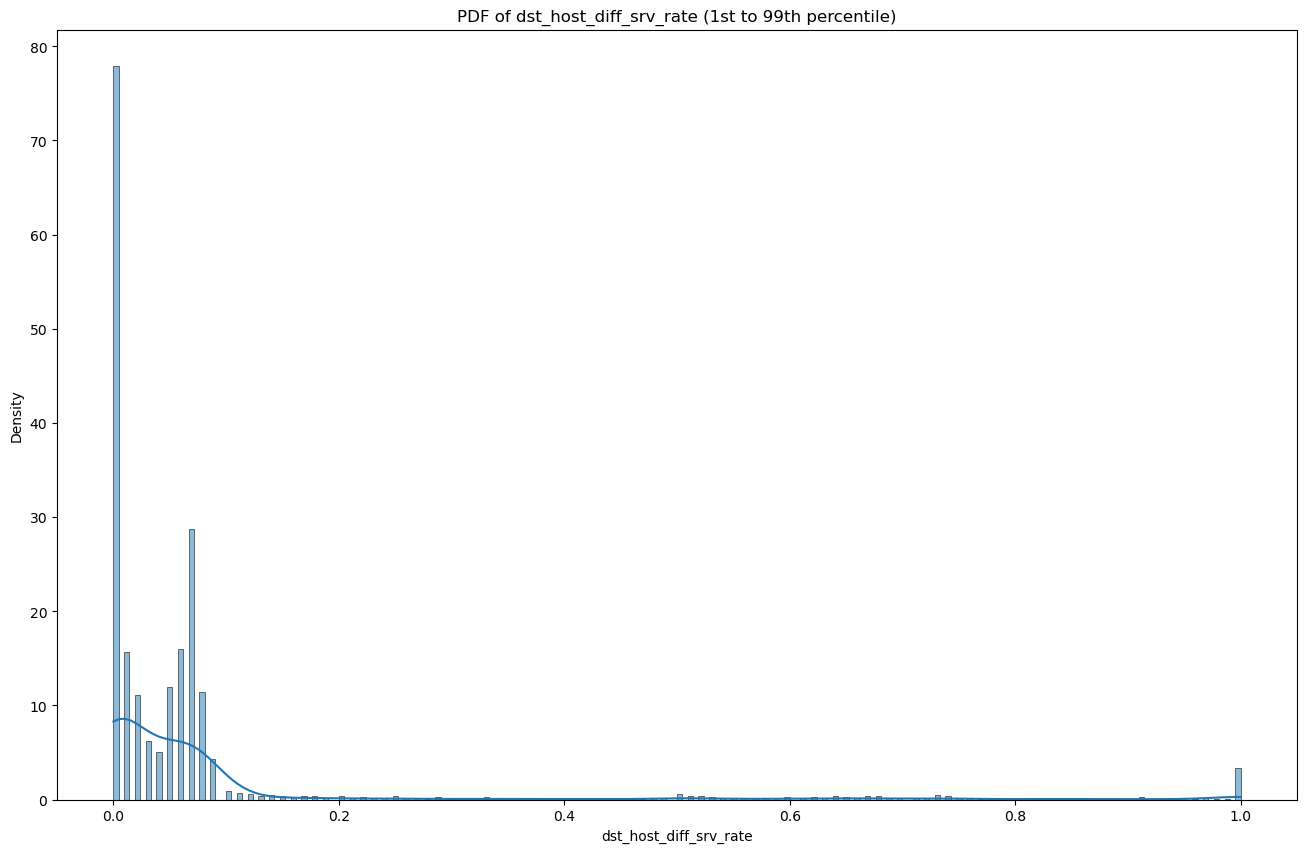

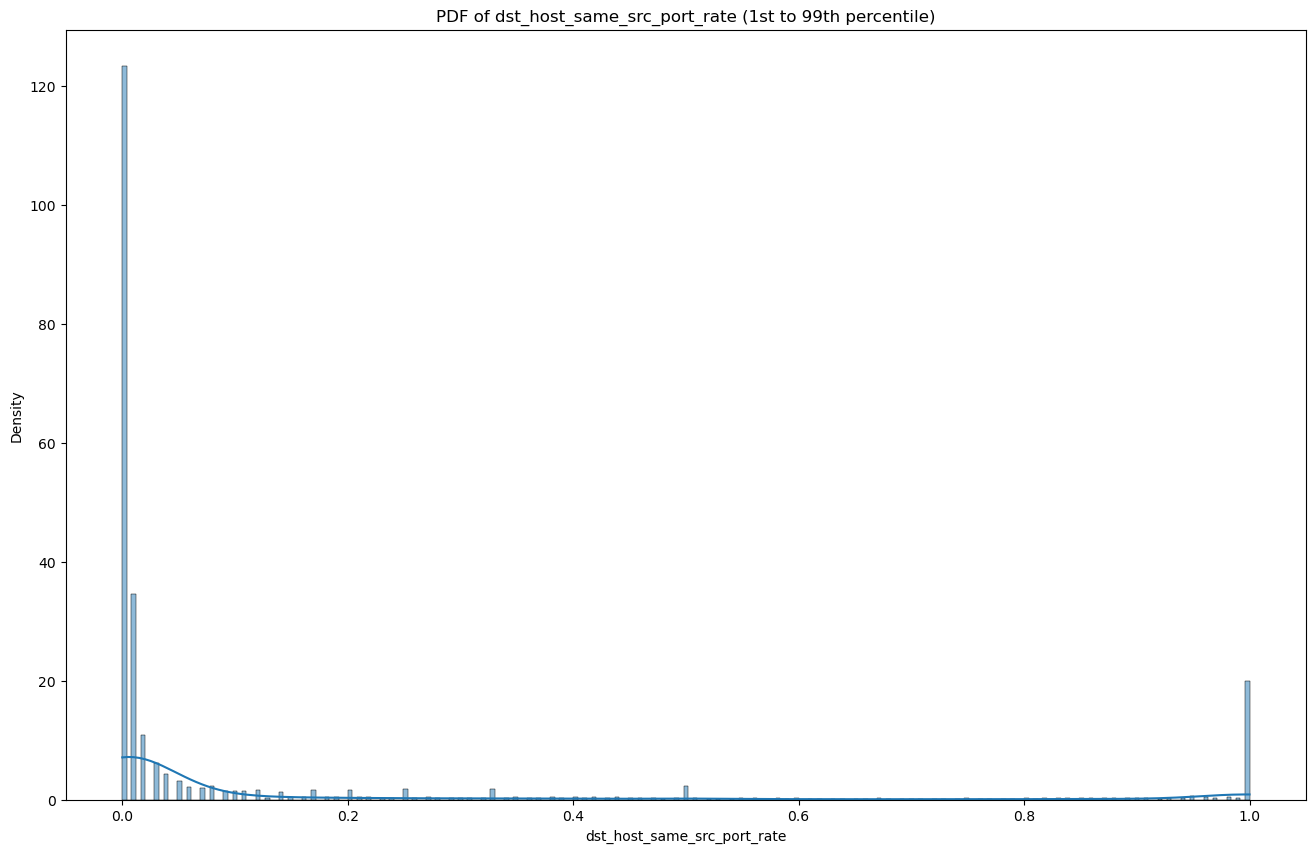

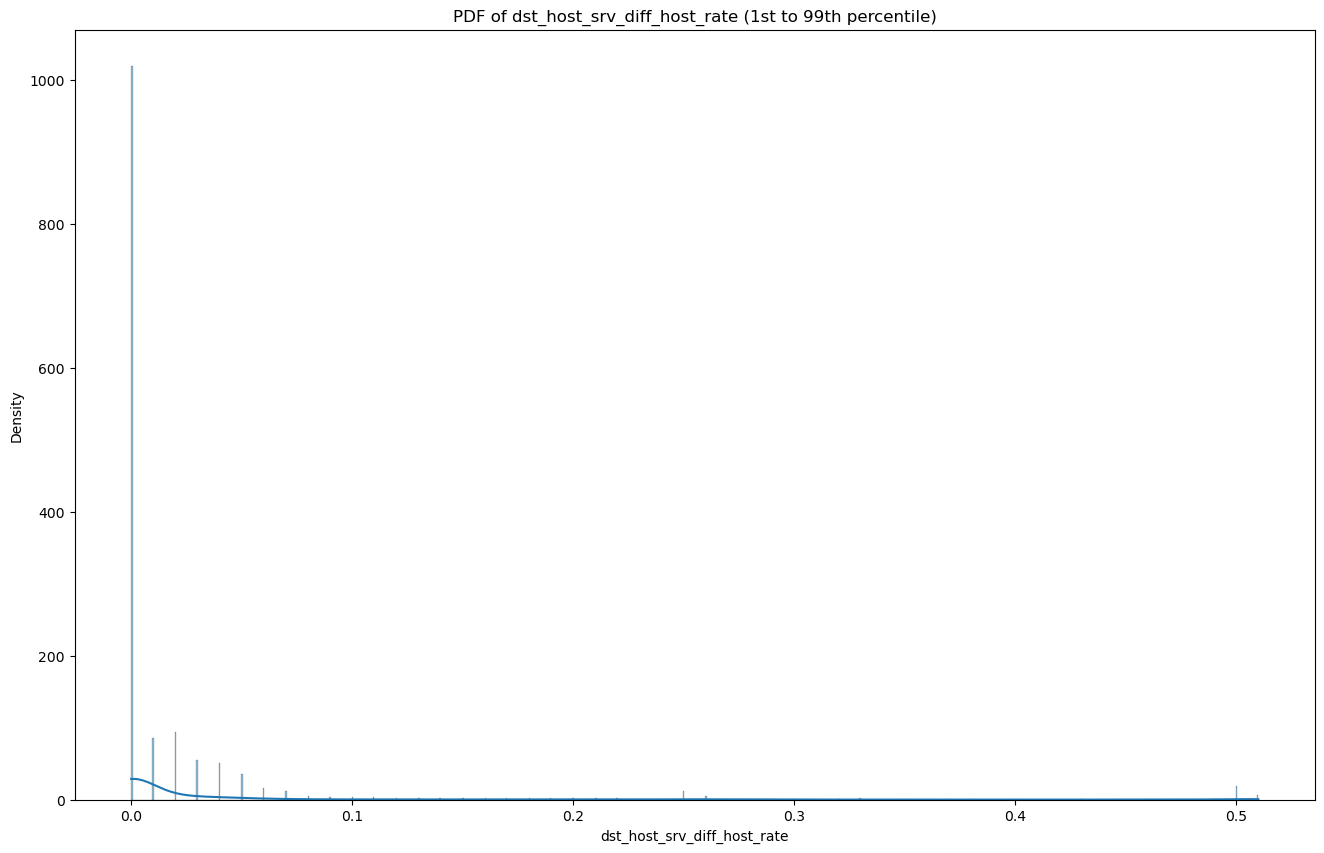

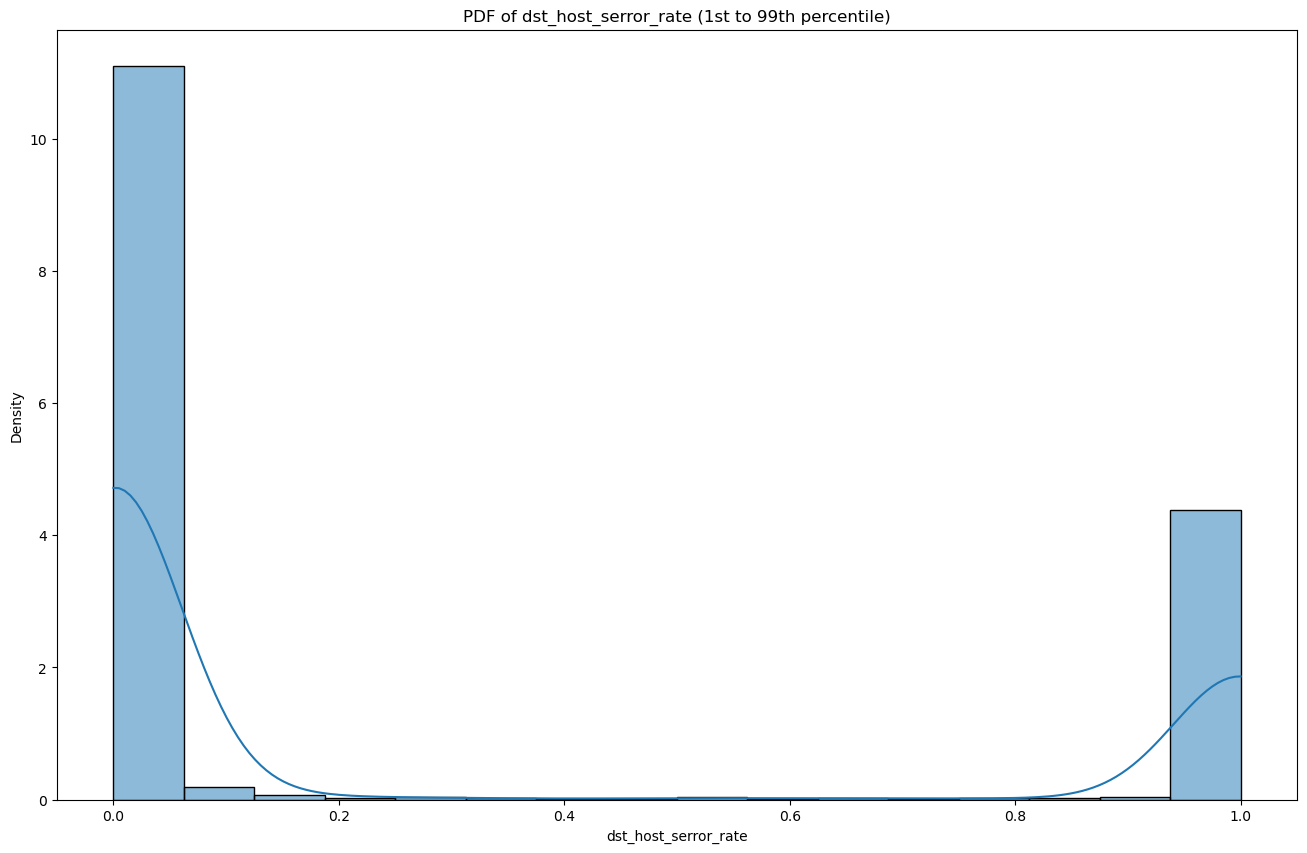

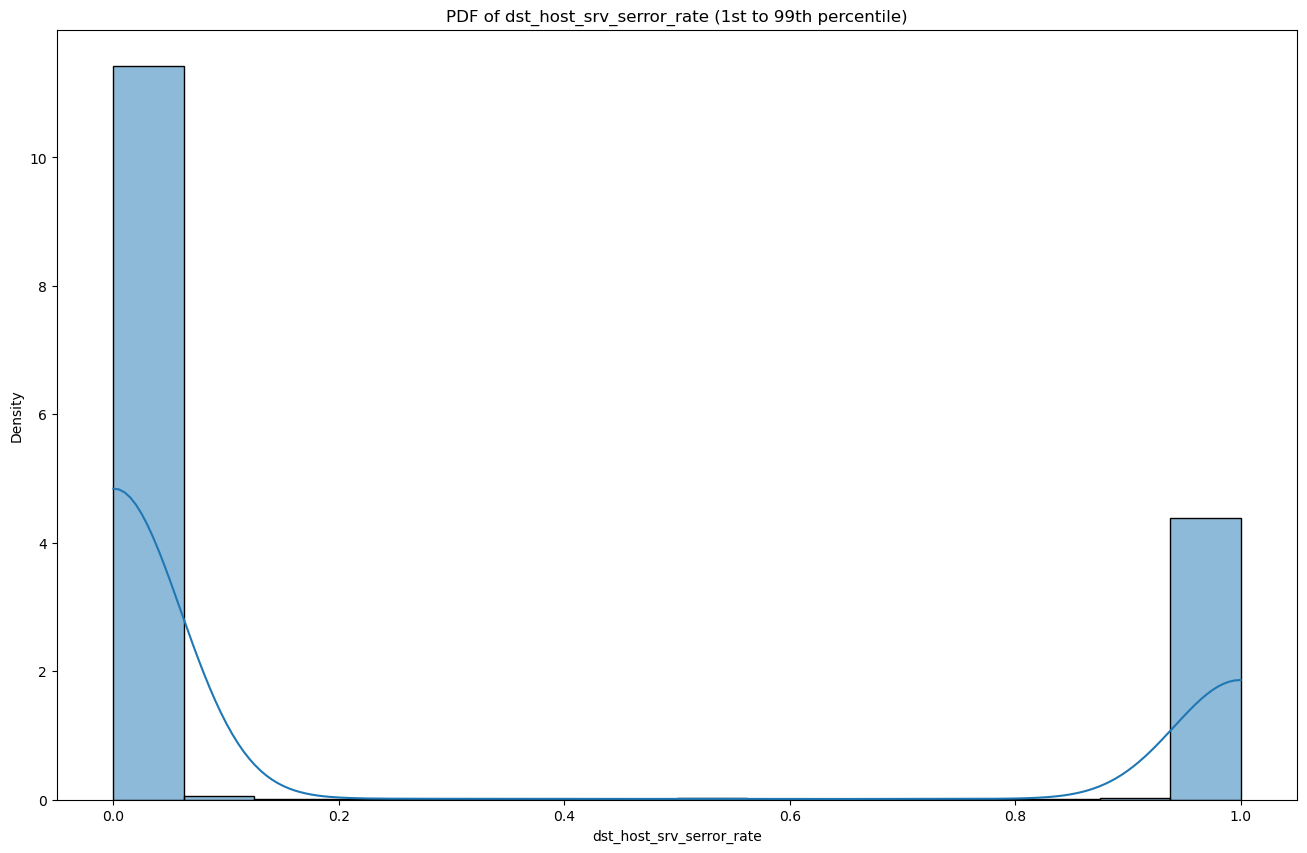

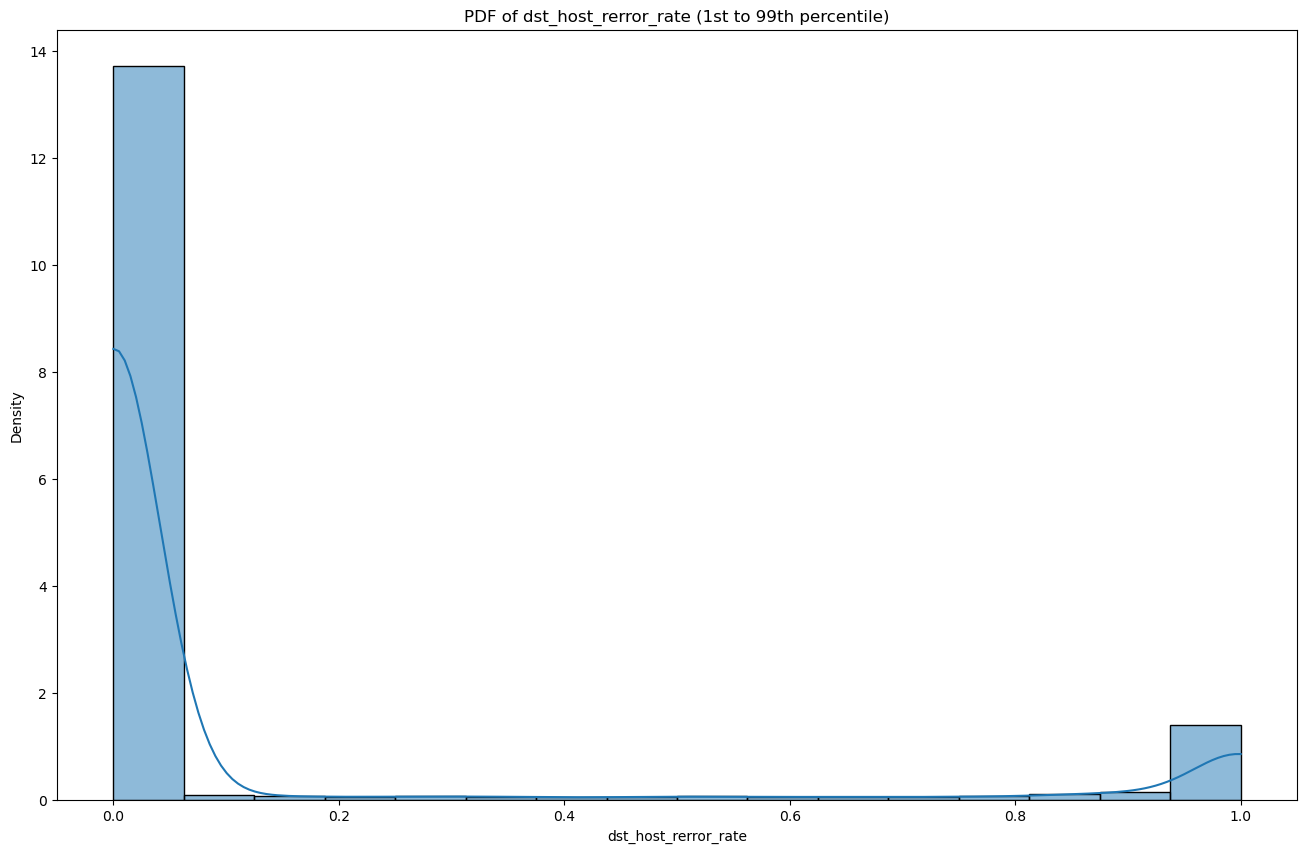

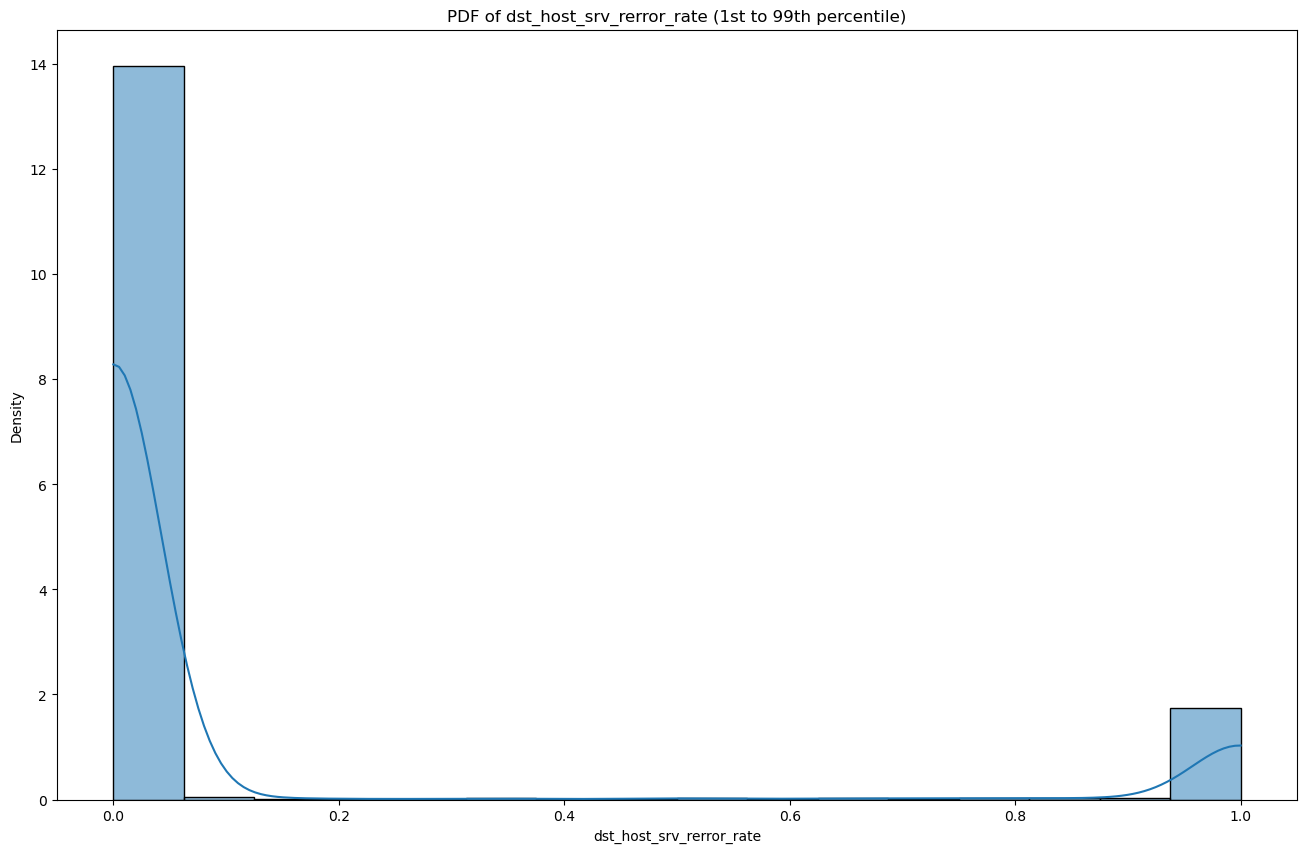

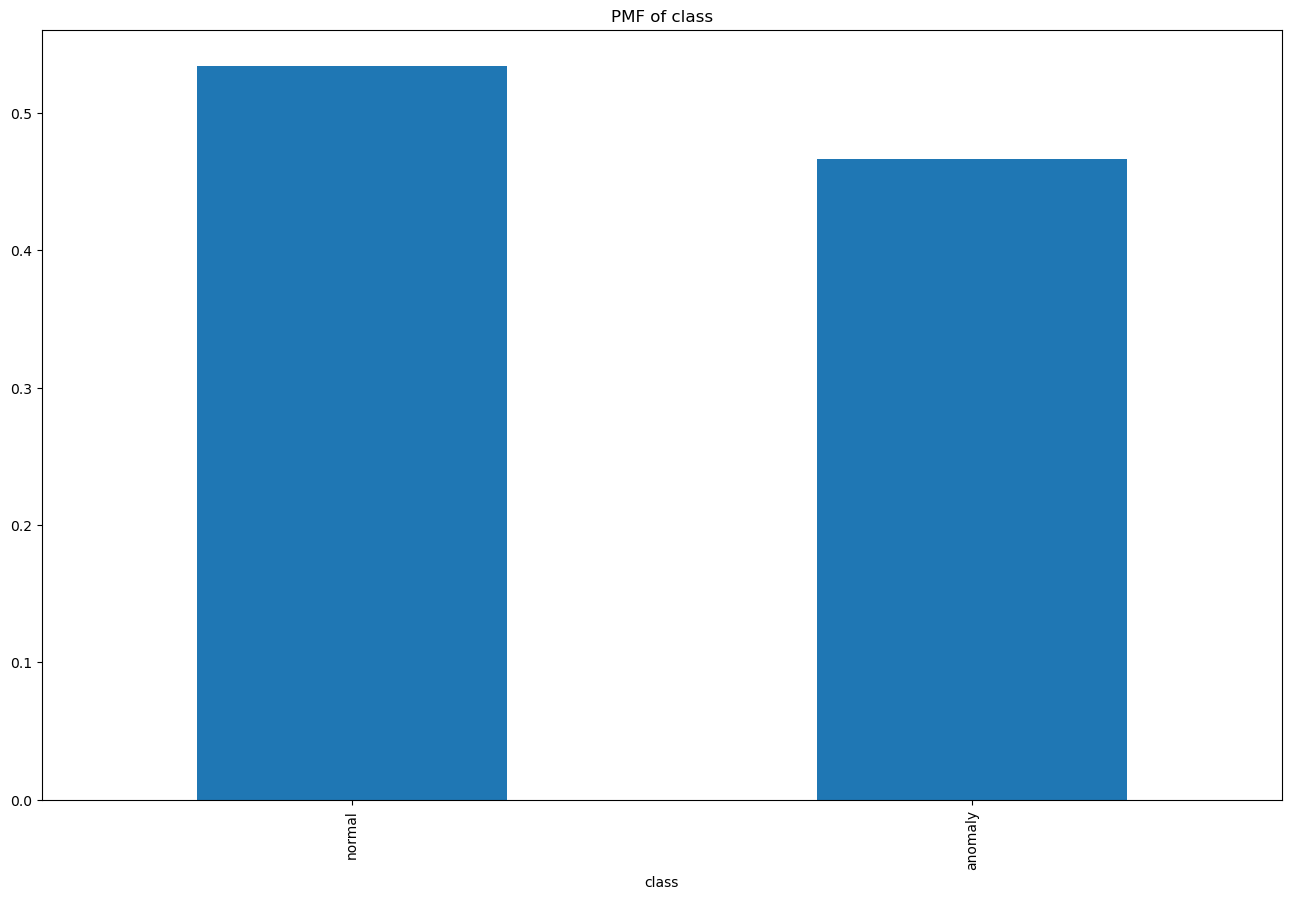

In [23]:
# 2. calculate and plot the pmf or pdf (depending on the type of data)
def plot_pdf_pmf(col):
    # DEBUGGING print(f"\nprocessing column: {col}")

    # for categorical data
    if data[col].dtype == 'object':
        unique_values = data[col].nunique()
       # DEBUGGING print(f"{col} is categorical with {unique_values} unique values.")

        if unique_values > 1:
            pmf = data[col].value_counts(normalize=True)
            plt.figure(figsize=(16, 10))
            pmf.plot(kind='bar', title=f'PMF of {col}')
            plt.xticks(rotation=90)
            plt.show()
        else:
            print(f"skipping {col}: not enough unique values.")

    # for continuous (numeric) data
    else:
        non_null_count = data[col].notnull().sum()
        # DEBUGGING print(f"{col} is continuous with {non_null_count} non-null values.")

        if non_null_count > 1:
            plt.figure(figsize=(16, 10))
            # plot only values within the 1st and the 99th percentiles to avoid extreme outliers and excess memory usage
            limited_data = data[col].dropna() # drops the null values
            limited_data = limited_data[limited_data.between(limited_data.quantile(0.01), limited_data.quantile(0.99))]
            sns.histplot(limited_data, kde=True, stat='density')
            plt.title(f'PDF of {col} (1st to 99th percentile)')
            plt.show()
        else:
            print(f"skipping {col}: not enough non-null values.")


# Loop through all columns
for col in data.columns:
    try:
        plot_pdf_pmf(col)
    except Exception as e:
        print(f"error processing column {col}: {e}")

In [ ]:
# 3. calculate and plot the CDF for each field
def plot_cdf(col):
    if data[col].dtype != 'object':
        sorted_data = np.sort(data[col].dropna())
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        plt.figure(figsize=(16, 10))
        plt.plot(sorted_data, cdf)
        plt.title(f'CDF of {col}')
        plt.show()


for col in data.select_dtypes(include=[np.number]).columns:
    plot_cdf(col)

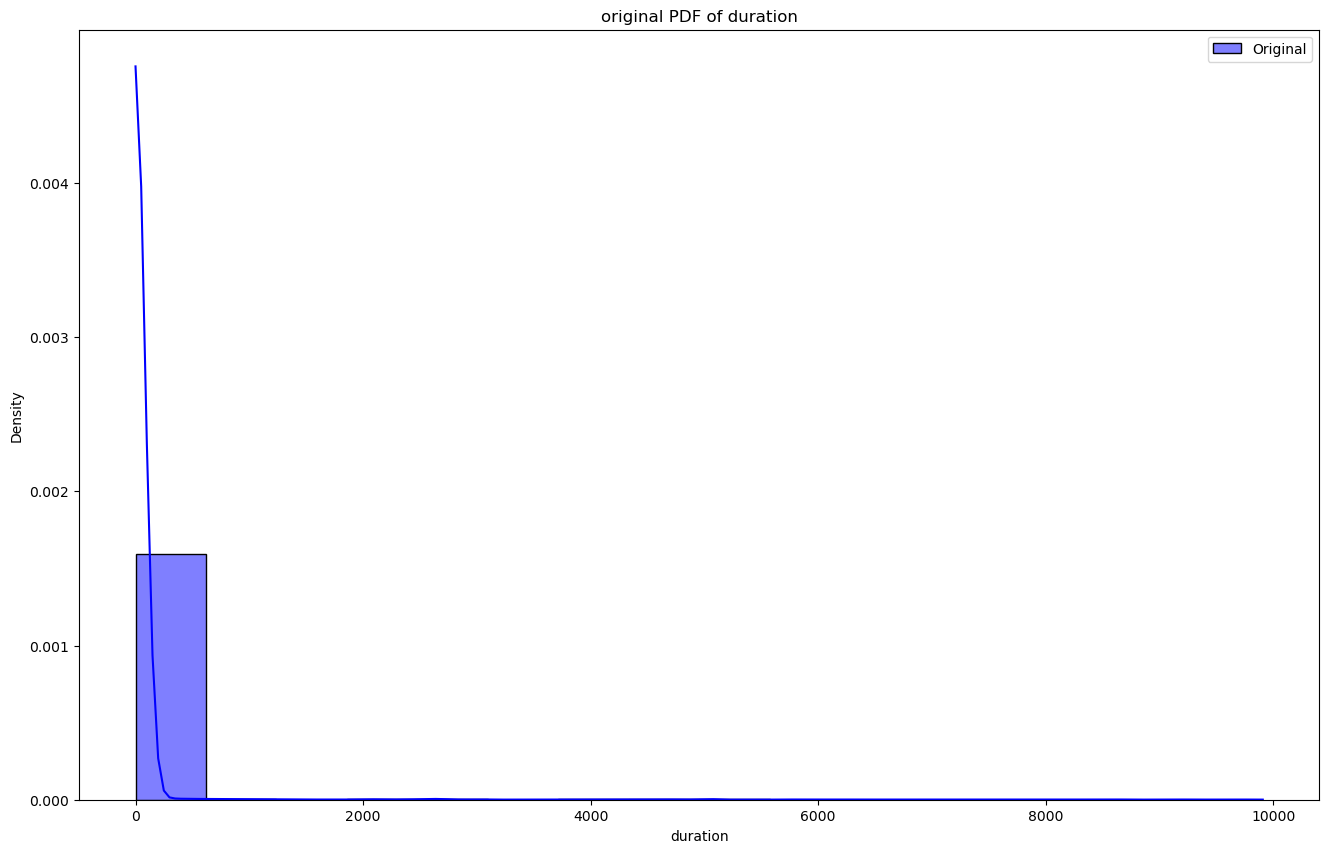

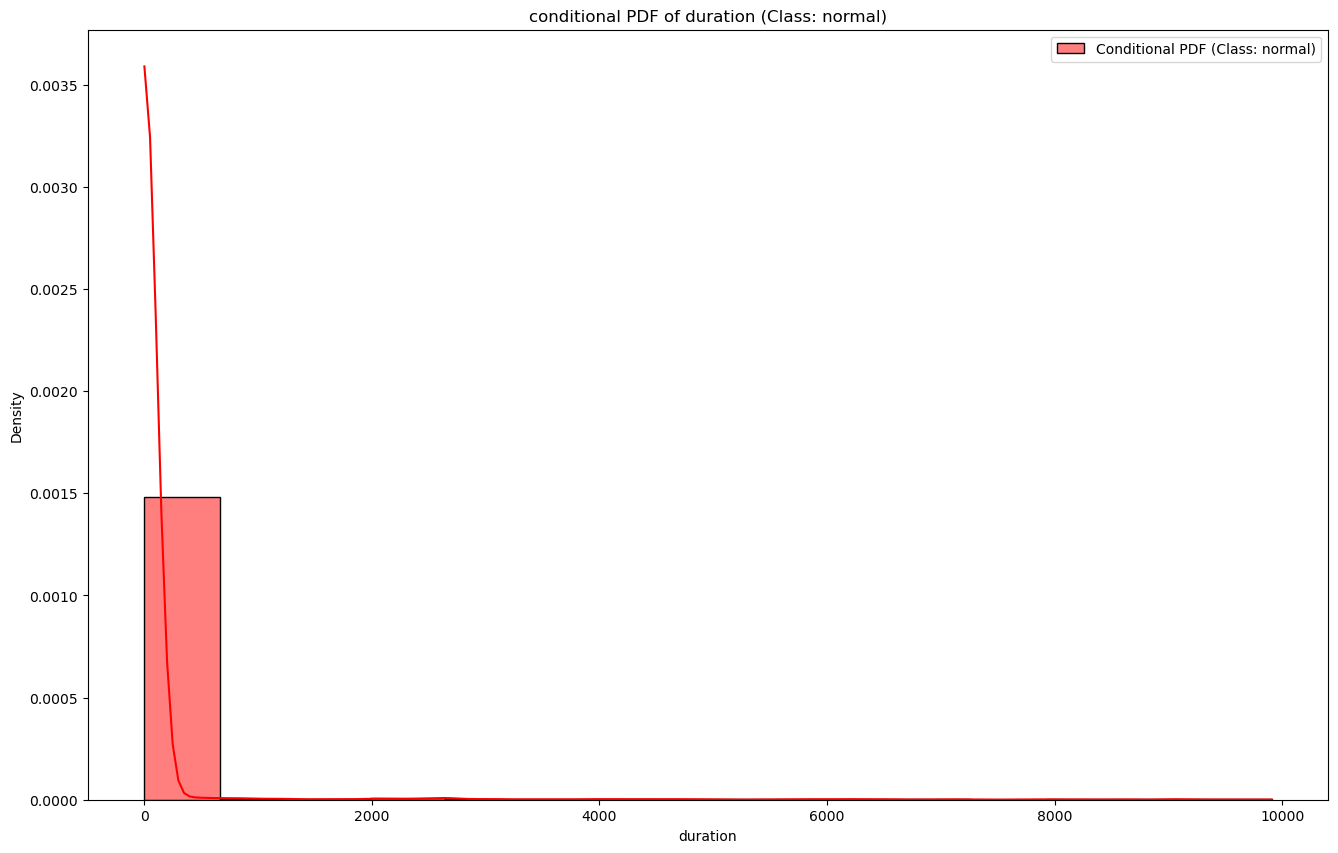

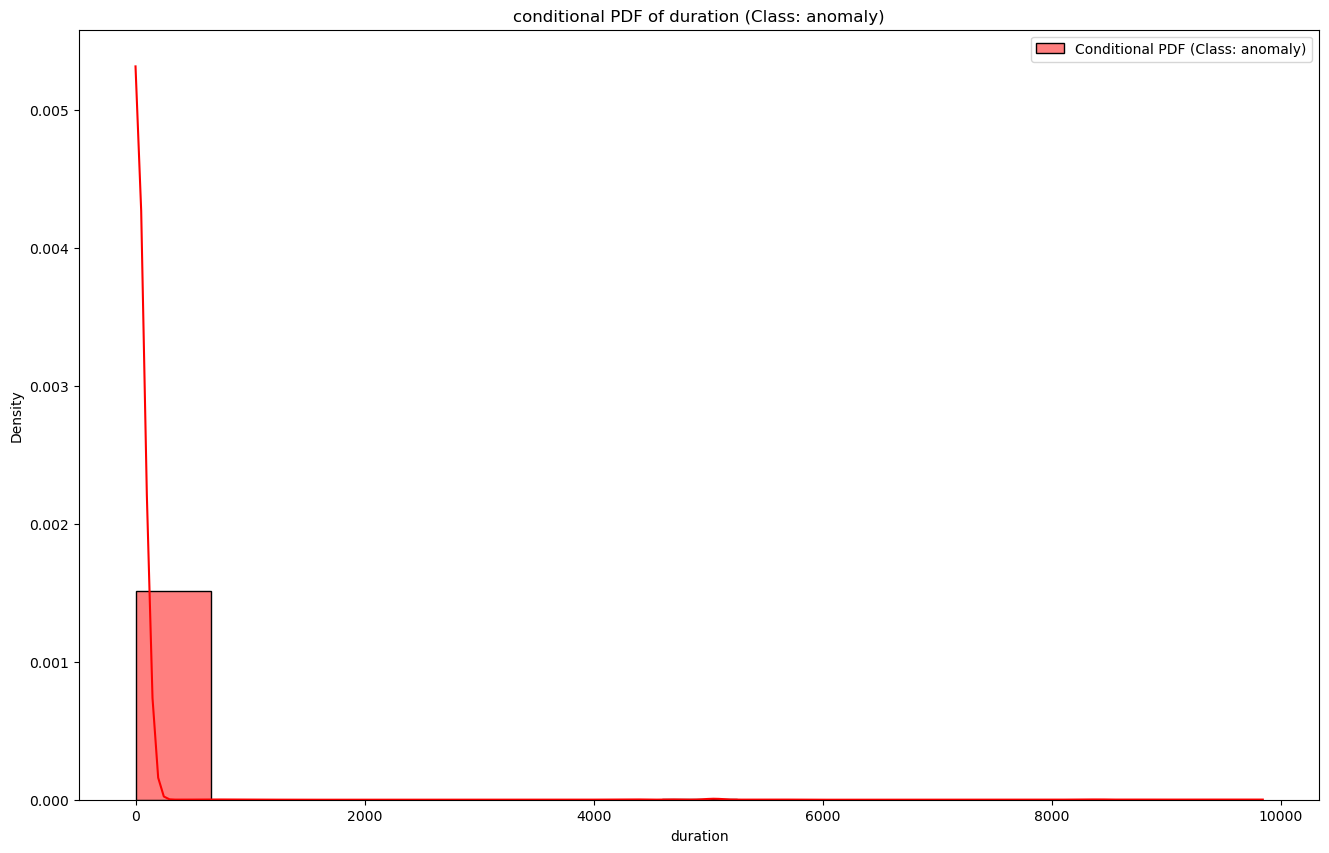

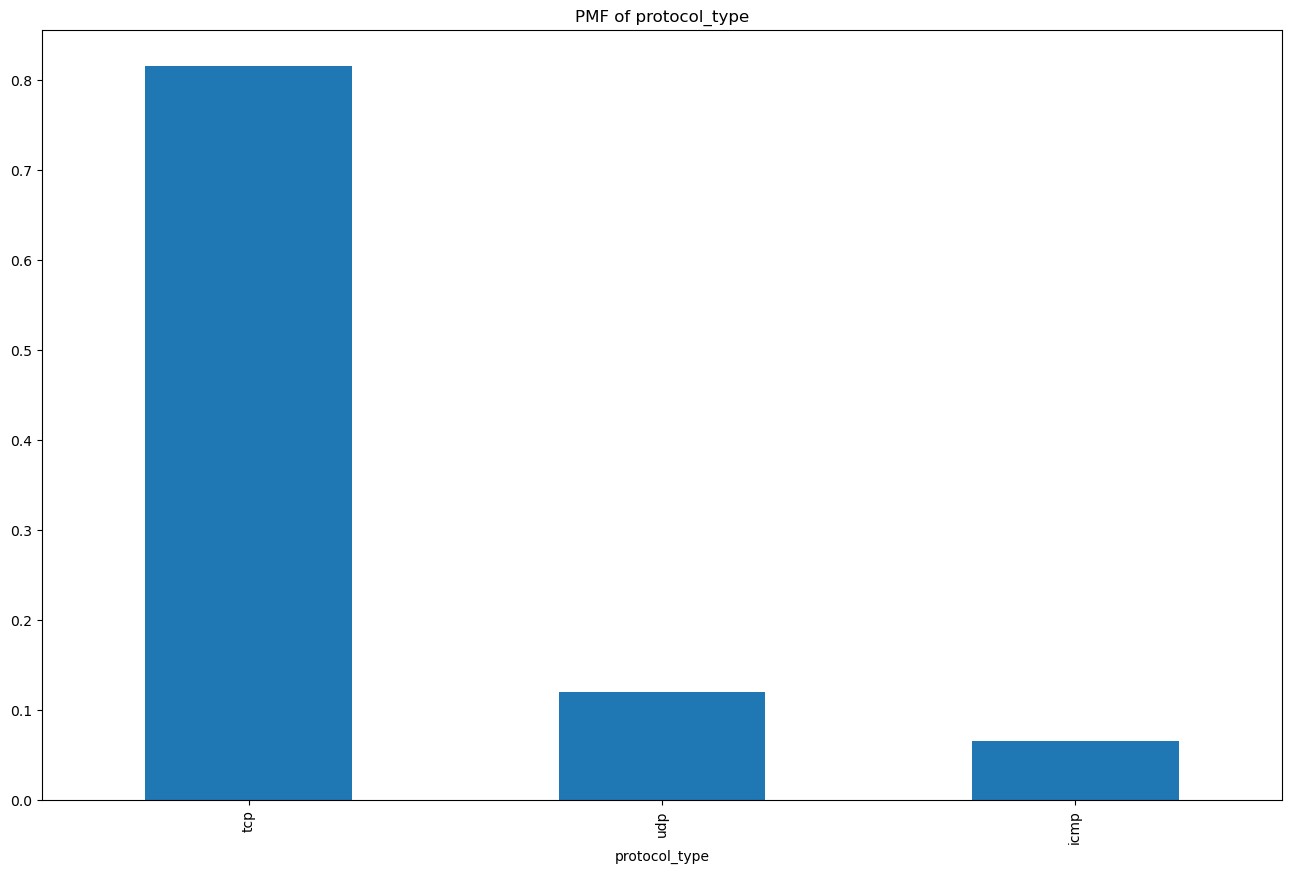

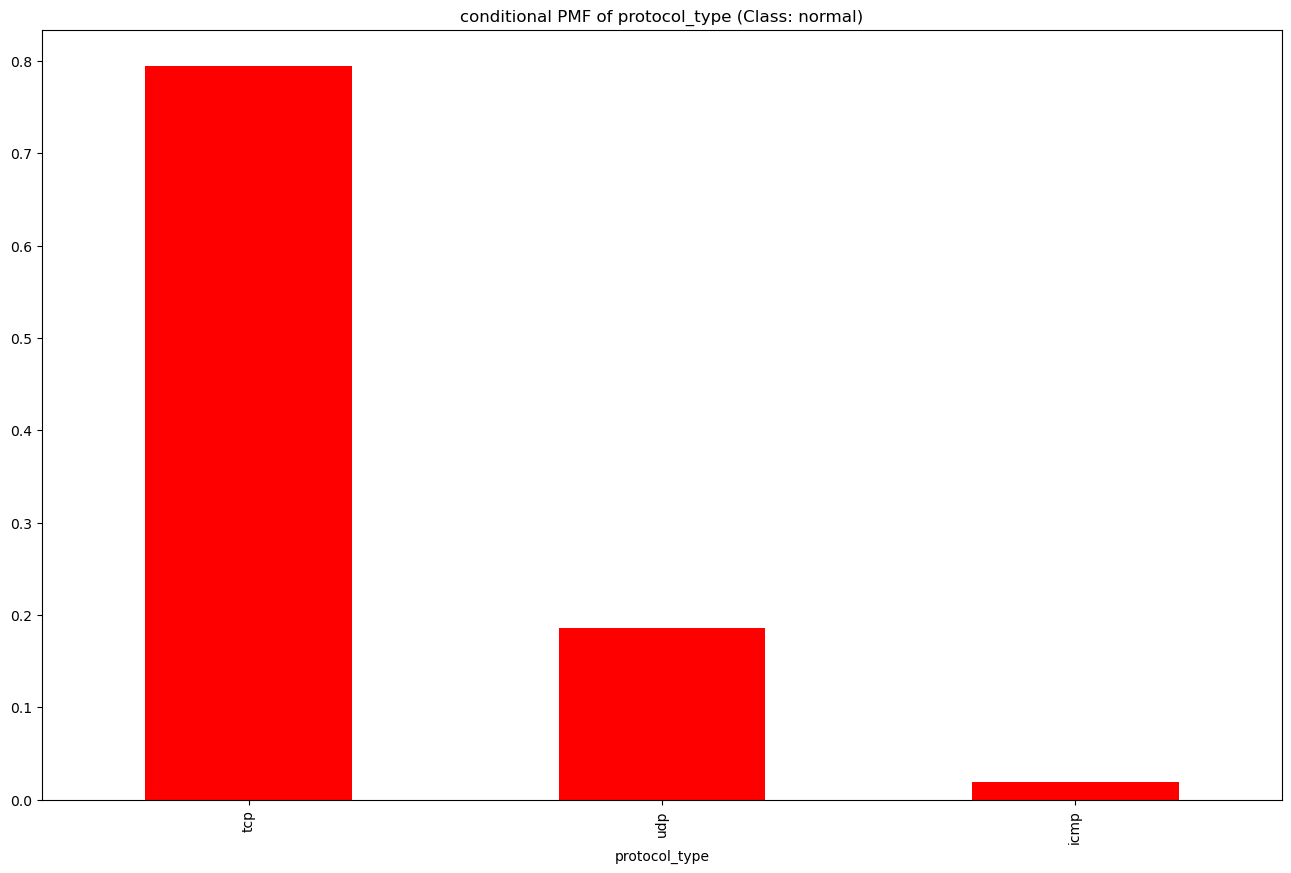

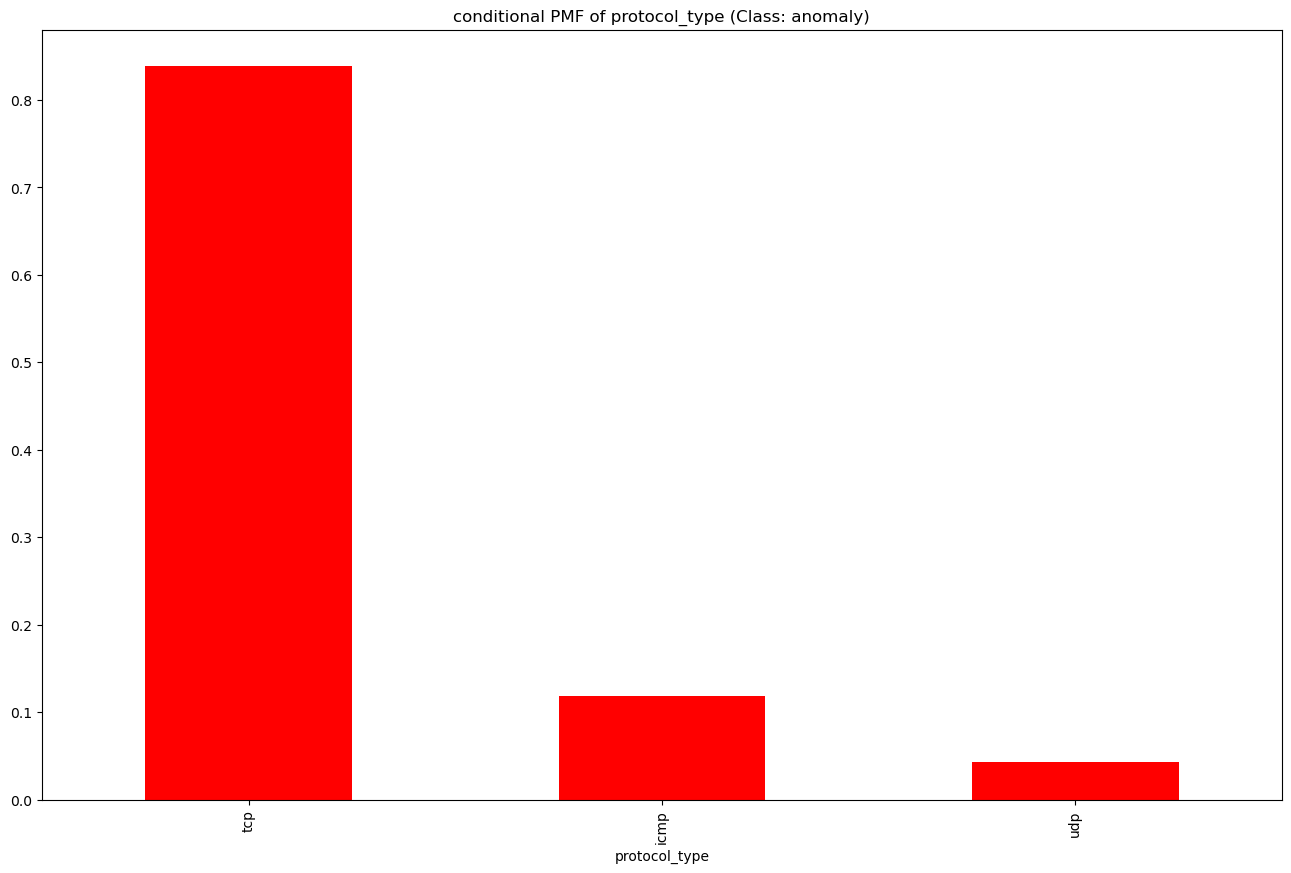

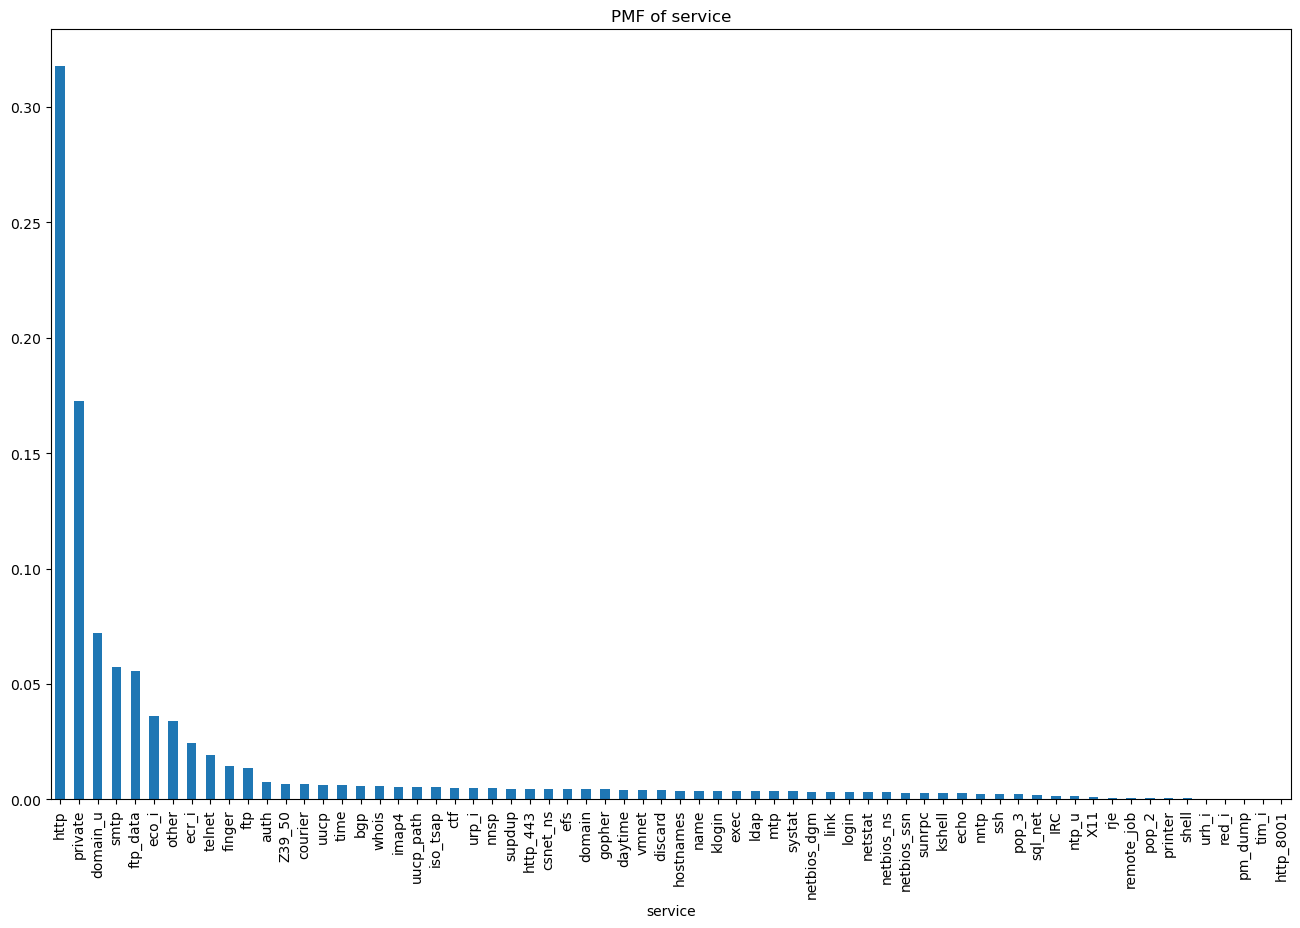

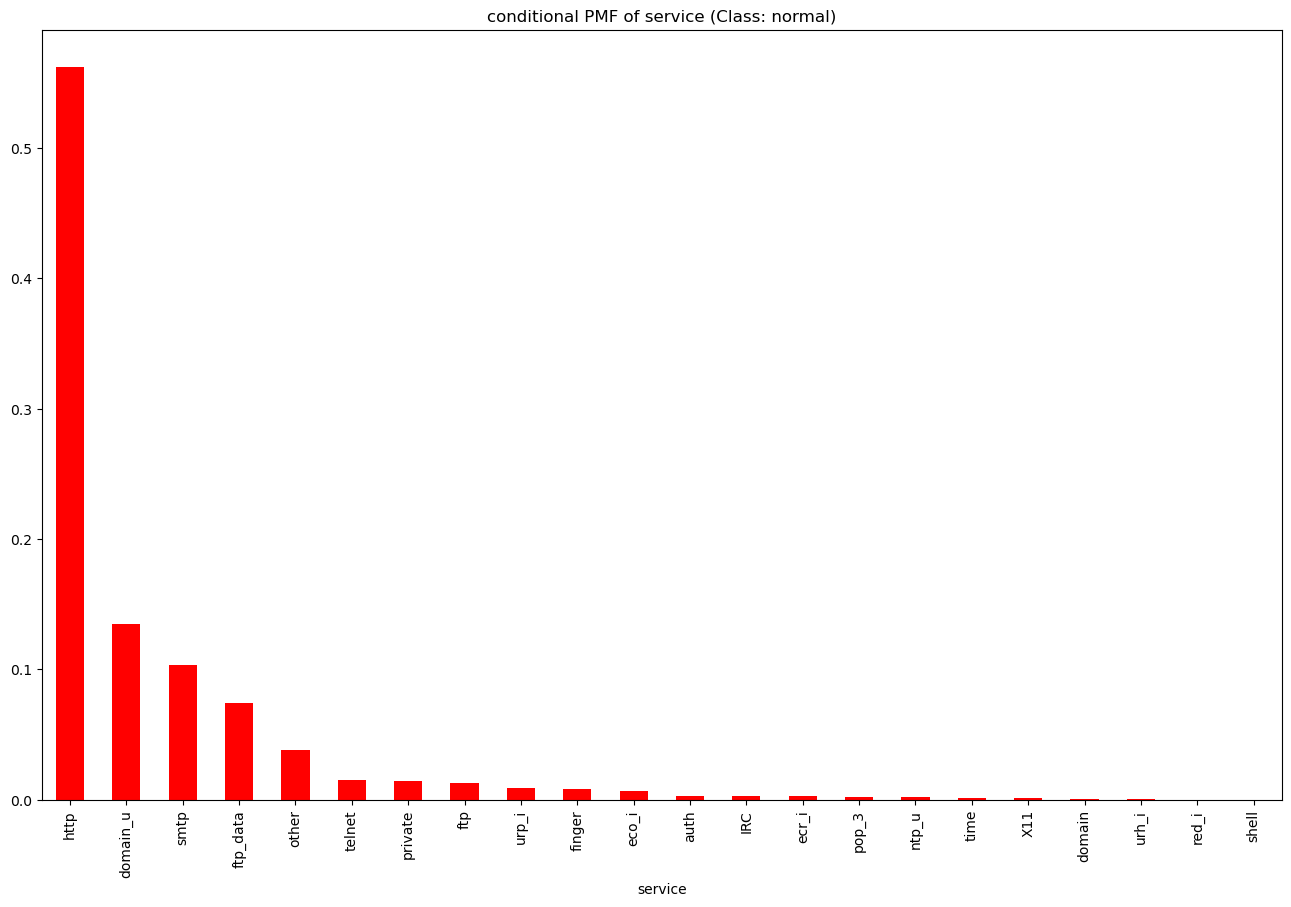

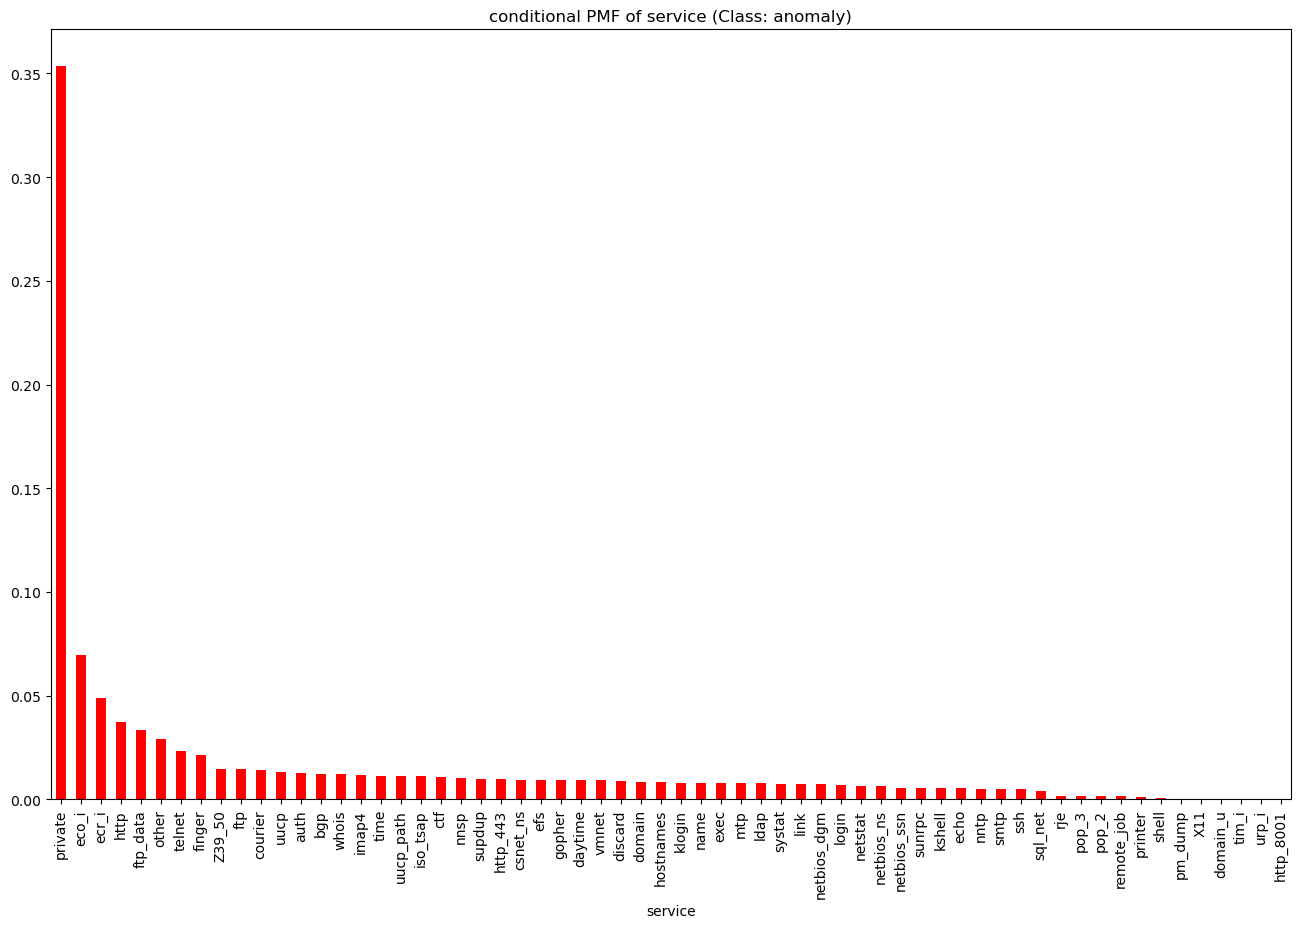

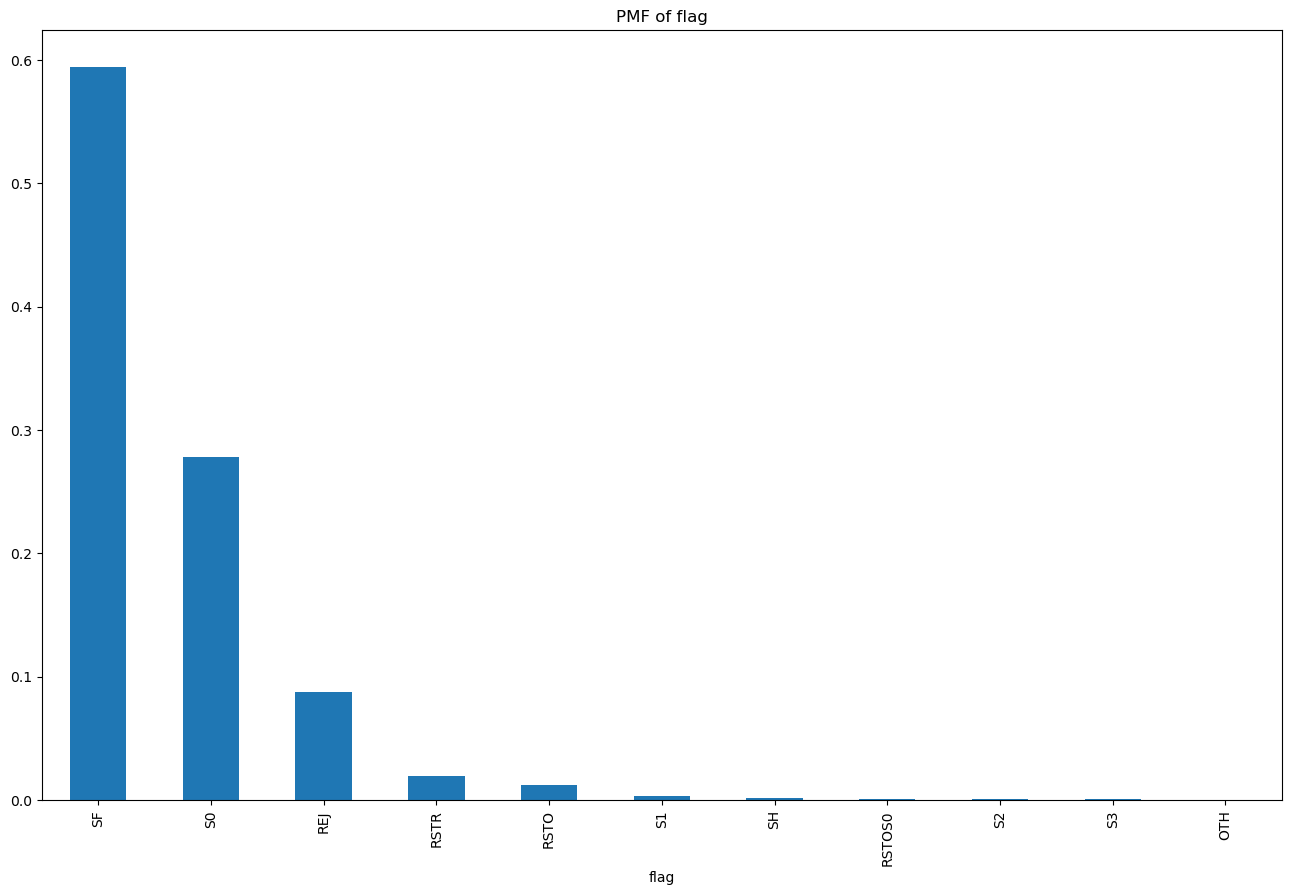

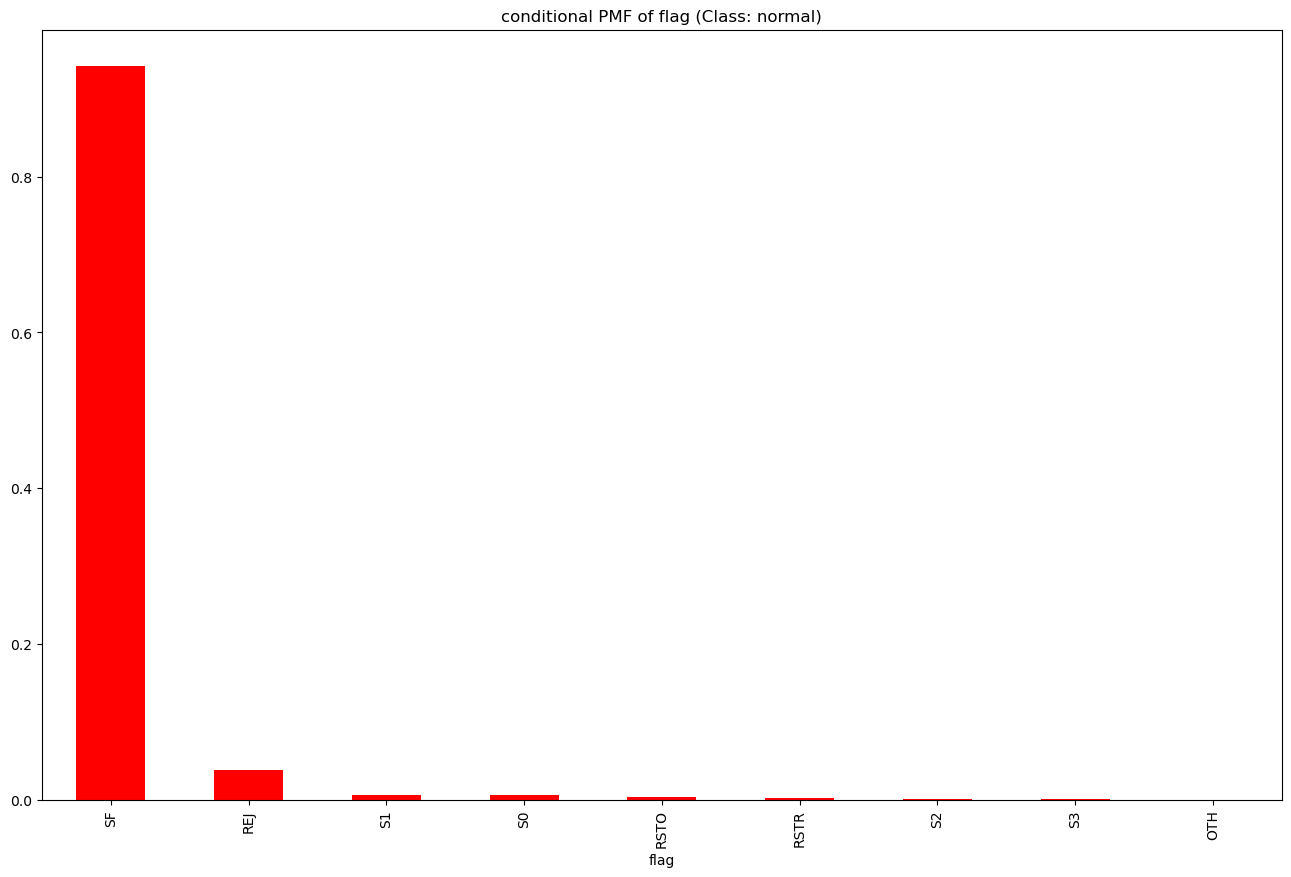

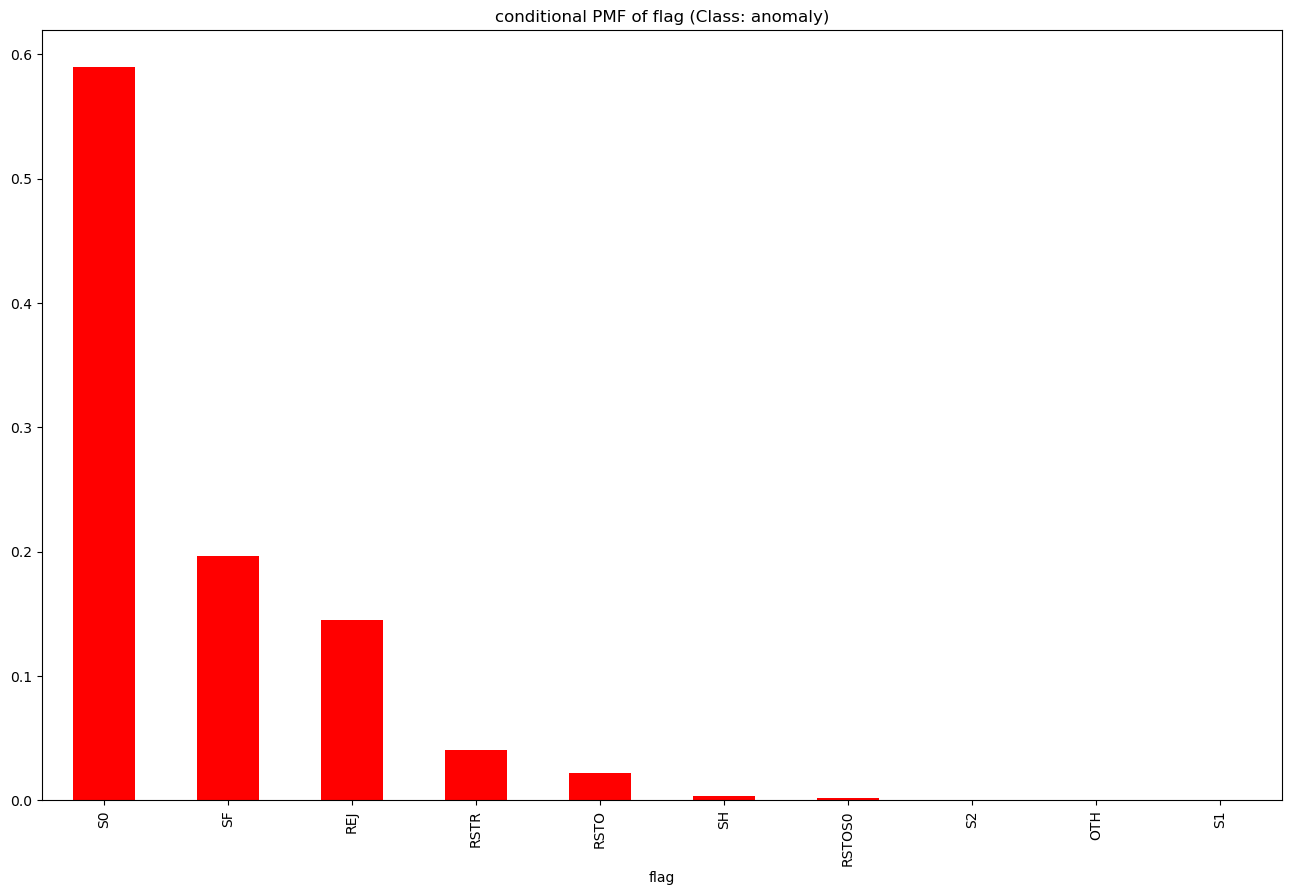

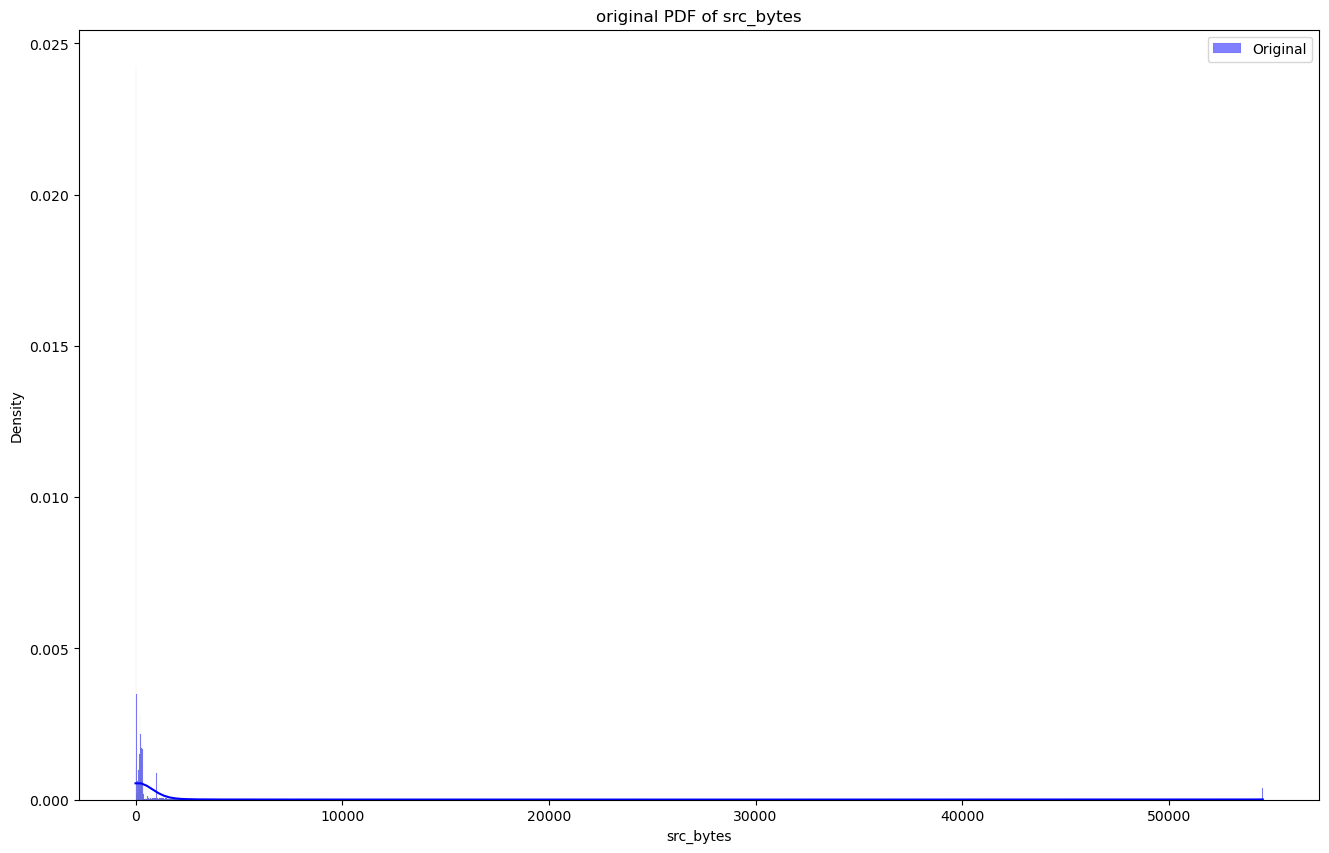

In [ ]:
# 4. PMF/PDF given the class (anomaly or normal)
# assuming 'class' is the column indicating anomaly/normal
class_col = 'class' # case sensitive i hate life


def plot_conditional_pdf(col):
    if data[col].dtype == 'object':
        unique_values = data[col].nunique()
        if unique_values > 1:
            # PMF for categorical data
            pmf = data[col].value_counts(normalize=True)
            plt.figure(figsize=(16, 10))
            pmf.plot(kind='bar', title=f'PMF of {col}')
            plt.xticks(rotation=90)
            plt.show()
        else:
            print(f"skipping {col}: not enough unique values.")

        # conditional PMF for each class
        for cls in data[class_col].unique():
            plt.figure(figsize=(16, 10))
            conditional_pmf = data[data[class_col] == cls][col].value_counts(normalize=True)
            conditional_pmf.plot(kind='bar', title=f'conditional PMF of {col} (Class: {cls})', color='red')
            plt.show()
    else:
        lower_bound = data[col].quantile(0.01)
        upper_bound = data[col].quantile(0.99)
        filtered_data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

        # PDF for continuous data
        plt.figure(figsize=(16, 10))
        sns.histplot(filtered_data[col], kde=True, stat='density', color='blue', label='Original')
        plt.title(f'original PDF of {col}')
        plt.legend()
        plt.show()

        for cls in filtered_data[class_col].unique():
            plt.figure(figsize=(16, 10))
            sns.histplot(filtered_data[filtered_data[class_col] == cls][col], kde=True, stat='density', color='red',
                         label=f'Conditional PDF (Class: {cls})')
            plt.title(f'conditional PDF of {col} (Class: {cls})')
            plt.legend()
            plt.show()


for col in data.columns:
    if col != class_col:
        plot_conditional_pdf(col)
    else:
        break

In [ ]:
# 5. scatter plot to indicate the relation between any two data fields

# sns.pairplot(data) this shit doesn't even work lmao
x_field = 'duration'
y_field = 'protocol_type'

plt.figure(figsize=(24, 16))
sns.scatterplot(data=data, x=x_field, y=y_field, color='red', alpha=0.5)
plt.title(f'Scatter Plot of {y_field} vs {x_field}')
plt.xlabel(x_field)
plt.ylabel(y_field)
plt.grid()

plt.show()

In [ ]:
# 6. calculate and plot the joint PMF/PDF of any two different fields

def plot_joint_pdf_pmf(col1, col2):

    if data[col1].dtype != 'object' and data[col2].dtype != 'object':
        # i can filter just one time to save computational power
        lower_bound = data[col1].quantile(0.01)
        upper_bound = data[col1].quantile(0.99)
        filtered_data = data[(data[col1] >= lower_bound) & (data[col1] <= upper_bound)]

        plt.figure(figsize=(24, 16))
        g = sns.jointplot(x=col1, y=col2, data=filtered_data, kind='kde')
        g.fig.suptitle(f'Joint PDF of {col1} and {col2}', y=1.02)  # y=1.02 to adjust title position
        # cant use plt.title as that'll make it's own figure and look idiotic
        plt.show()
    else:
        joint_pmf = pd.crosstab(data[col1], data[col2], normalize='all')
        plt.figure(figsize=(24, 16))
        sns.heatmap(joint_pmf, annot=True, cmap='Blues')
        plt.title(f'joint PMF of {col1} and {col2}')
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.show()


plot_joint_pdf_pmf('duration', 'protocol_type')

In [ ]:
# 7. joint PMF/PDF conditioned on the class
def plot_conditional_joint_pdf_pmf(col1, col2):
    for cls in data[class_col].unique():
        print(f"\nClass: {cls}")

        if data[col1].dtype != 'object' and data[col2].dtype != 'object':
            lower_bound = data[col1].quantile(0.01)
            upper_bound = data[col1].quantile(0.99)
            filtered_data = data[(data[col1] >= lower_bound) & (data[col1] <= upper_bound)]

            plt.figure(figsize=(24, 16))
            sns.jointplot(x=col1, y=col2, data=filtered_data[filtered_data[class_col] == cls], kind='kde')
            plt.title(f'conditional Joint PDF of {col1} and {col2} (Class: {cls})')
            plt.show()
        else:
            joint_pmf = pd.crosstab(data[data[class_col] == cls][col1], data[data[class_col] == cls][col2],
                                    normalize='all')
            plt.figure(figsize=(24, 16))
            sns.heatmap(joint_pmf, annot=True, cmap='Reds')
            plt.title(f'Conditional Joint PMF of {col1} and {col2} (Class: {cls})')
            plt.show()
plot_conditional_joint_pdf_pmf('duration', 'protocol_type')

In [ ]:
# 8. calculate the correlation between different data fields
#correlation_matrix = data.corr()
# cant include non-numeric types in the corr method
data_numeric = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = data_numeric.corr()
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('correlation matrix')
plt.show()

In [ ]:
# 9. find which field is dependent on the type of attack (anomaly/normal)

#for col in data.columns:
#    if col != class_col:
#        data_cleaned = data.dropna()
#        correlation_with_attack = data_cleaned.groupby('class')[col].mean()
#        print(f"\nfield: {col}")
#        print(f"mean values per class:\n{correlation_with_attack}")

numeric_fields = data.select_dtypes(include=['float64', 'int64']).columns
categorical_fields = data.select_dtypes(include=['object']).columns

print("analyzing numeric fields:")
for col in numeric_fields:
    if col != class_col:  # avoid grouping by the class column itself (shouldn't be the case here since class isn't numerical but idc)
        correlation_with_attack = data.groupby(class_col)[col].mean()
        print(f"\nField: {col}")
        print(f"mean values per class (Anomaly/Normal):\n{correlation_with_attack}")

print("\nAnalyzing Categorical Fields:")
for col in categorical_fields:
    if col != class_col:  # avoid using the class column itself
        correlation_with_attack = data.groupby(class_col)[col].value_counts()
        print(f"\nField: {col}")
        print(f"value counts per class (Anomaly/Normal):\n{correlation_with_attack}")